In [1]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


# Deep Seasons: Monthly Subseasonal Climate Prediction

## Overview
This notebook implements a deep learning model for subseasonal climate predictions, specifically forecasting monthly mean **Sea Surface Temperature (SST)** and **Zonal Wind (U850)** components. The model employs a Transformer-based architecture (Informer) trained on ERA5 reanalysis data.

## Key Features
- **Target Variable**: Monthly mean SST predictions with lead times up to 4 months
- **Input Variables**: SST and U850 (850 hPa Zonal Wind) as primary predictors
- **Prediction Horizon**: 12-month forecast horizon
- **Architecture**: Informer (attention-based encoder-decoder) with ProbSparse attention mechanism
- **Data**: ERA5 reanalysis over global domain with focus on tropical regions
- **Comparison**: Optional verification against dynamical forecasts (e.g., seasonal models)

## Model Configuration
- **Encoder/Decoder Layers**: 2 layers with 8 attention heads each
- **Hidden Dimension**: 256 (d_model)
- **Feed-forward Dimension**: 256
- **Context Window**: 48 months
- **Loss Function**: Negative Log-Likelihood with Student-t distribution output
- **Training Period**: 1940-2005
- **Validation Period**: 2006-2015
- **Test Period**: 2016-2022

## Modifications from Base Version
- **Strong discount factor** (0.9) applied to forecasts to weight recent predictions more heavily
- **Limited lag sequence** [1,2,3,4] for computational efficiency
- **Enhanced verification metrics** for comparison with operational dynamical models

In [2]:
import os,sys
import math
import pickle
import tabulate as tab
import datetime
import time as tm
import random

import matplotlib.pyplot as plt
from collections  import namedtuple


import numpy as np
import scipy.linalg as sc
import scipy.signal as sig
import numpy.linalg as lin
from scipy import stats
# from scipy.signal import argrelextrema

from alive_progress import alive_bar
import time

import xarray as xr
import pandas as pd

# import numpy.polynomial.polynomial as poly

# AI Imports
from sklearn import datasets		# To Get iris dataset
from sklearn import svm   
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# import transformers as tr
# import torch.nn.functional as F

#=======================================================================
#                             PATHS
#=======================================================================
homedir = os.path.expanduser("~")
print('Root Directory for Data ',homedir)
drop_home = #INSERT HERE THE ROOT DORECTORY FOR "ZAPATA" AND "AIMODELS"
sys.path.insert(1, homedir + drop_home + '/Zapata')
sys.path.insert(0, homedir + drop_home + '/AIModels')


#Working Directory
wkdir =  drop_home + # INSERT HERE YOUR WORKING DIRECTORY
dddir =  drop_home + # INSERT HERE THE LOCATION OF MONTHLY MEAN ERA5 DATA
#=======================================================================





os.chdir(homedir + wkdir)
print('Working Directory set to ',os.getcwd())

# import klus.algorithms as al
# # import d3s.domain as domain
# import klus.kernels as kernels
# # import d3s.tools as tools

import zapata.computation as zcom
import zapata.data as zd
import zapata.lib as zlib
import zapata.mapping as zmap
import AIModels.AIutil as zai
import AIModels.AIClasses as zaic
import AIModels.ClimFormer as zcf
import AIModels.UtilPlot as utp
import AIModels.ModelTraining as mtr
import AIModels.Validation as val
# import AIModels.LocalInformer as ltr
import AIModels.Informer.modeling_informer as ltr
import AIModels.Informer.configuration_informer as ctr

today_date = datetime.date.today().strftime("%Y-%m-%d")

# from scipy.spatial import distance
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KernelDensity

env = zlib.get_environment_info('interpreter')
print(f'\n\nNotebook operating in ENV {env} -- {today_date}\n')

#%pdb
%load_ext autoreload
%autoreload 2
%matplotlib inline


Root Directory for Data  /Users/antonionavarra
Working Directory set to  /Users/antonionavarra/CMCC Dropbox/Antonio Navarra/AI
ddsapi not available, not in BOOKOORT or ERA5 conda environment


Notebook operating in ENV /Users/antonionavarra/anaconda3/envs/AI2-2026/bin/python -- 2026-01-24



## Notebook Workflow

### Execution Flow:
1. **Environment Setup**: Initialize MPS fallback, import libraries, configure paths
2. **Data Configuration**: Define variables, EOF parameters, normalization settings
3. **Data Loading**: Load ERA5 fields, compute EOF decompositions, extract features
4. **Model Architecture**: Configure Informer model with hyperparameters
5. **Training**: Train with Adam/AdamW optimizers, validation monitoring, early stopping
6. **Inference**: Generate predictions on all data splits
7. **Analysis**: Visualize forecasts, compute verification metrics, compare with dynamical models

### Required Packages:
- PyTorch (torch, torch.nn, torch.optim)
- Data: xarray, pandas, numpy
- Custom: Zapata library, AIModels module with Informer implementation

## Section 1: Environment Setup and Data Configuration

### Data Source
- **Reanalysis Product**: ERA5 (ECMWF 5th generation)
- **Temporal Resolution**: Monthly means
- **Spatial Domain**: Global (WORLD) and Tropical (TROPIC) regions
- **Pressure Levels**: Multiple levels (500 hPa, 850 hPa, 1000 hPa, 10m)

### Data Processing Options
- **Normalization**: Anomaly normalization (deviations from climatology)
- **Encoding**: SVD (Singular Value Decomposition) compression
- **Variance Retention**: Automatic (keeps all or specified fraction)
- **Smoothing**: Optional seasonal filtering
- **Detrending**: Disabled in current configuration

### Data Field Definition and EOF Extraction

The `Field` class (from `AIModels.AIClasses`) encapsulates data extraction and EOF computation. Each field is defined by:
- **Variable Code**: Physical variable identifier (e.g., 'Z' for geopotential, 'U' for zonal wind, 'SST')
- **Pressure Level(s)**: Atmospheric level(s) (e.g., 500 hPa, 850 hPa)
- **Geographic Domain**: Region selection (WORLD, TROPIC, EUROPE, etc.)
- **Number of EOFs**: Principal components to retain (e.g., 25 EOFs)
- **dropX Flag**: Whether to exclude longitude dimension for zonal mean analysis

The EOF (Empirical Orthogonal Function) decomposition reduces high-dimensional spatial fields to their dominant spatial patterns, enabling efficient input representation for the neural network.

In [3]:
# Configure case

case = 'W620d'  # Case identifier/experiment name


# Data source and preprocessing configuration
shift = 'ERA5'      # Data source: 'ERA5' reanalysis product
SMOOTH = False       # Apply seasonal smoothing filter (True/False)
period = 'ANN'      # Temporal aggregation period: 'ANN' for annual, or specific season
comp_diff = False   # If True, predict differences instead of absolute values

data_name = case 
normalization = 'anom'          # Normalize data as anomalies (deviations from climatology)
write_result = False            # Save output results to netCDF file
only_valtrain_eof = True        # Use only training+validation data to compute EOF patterns (not independent test set)
clim_train = True               # Compute anomalies relative to training period climatology only
verify_dyn = True               # Compare predictions against dynamical model forecasts for verification
choose_device = 'MPS'           # Computing device: 'MPS' for Apple Silicon, 'GPU' for CUDA, 'CPU' for CPU
encode_svd = True               # Use Singular Value Decomposition (SVD) for data encoding/compression
var_retained = None             # Fraction of variance to retain after SVD (None=keep all; e.g., 0.99=99%)

# Define EOF (Empirical Orthogonal Function) computation period
if only_valtrain_eof:
    # Use only training and validation data for EOF extraction
    if SMOOTH:
        eof_interval = ['1940-03-01', '2015-12-01']  # With seasonal smoothing
    else:
        eof_interval = ['1940-01-01', '2015-12-01']  # Without smoothing
else:
    eof_interval = None   # Use all available data

# Define climatology computation interval
if clim_train:
    clim_int = eof_interval  # Use same interval as EOF
else:
    clim_int = None  # Use full data period

# Select and define input/output variables
# Variables are defined using the Field class with parameters:
# Field(variable_code, level(s), region, num_EOFs, dropX=exclude_longitude)

# [SST,T2M], Smooth, [8,16]
# Z200 = zaic.Field('Z',['200'],'WORLD',15, dropX=True)  # Geopotential at 200hPa (upper troposphere)
Z500 = zaic.Field('Z',['500'],'WORLD',25,dropX=False)    # Geopotential at 500hPa (mid-troposphere)
# V850 = zaic.Field('V',['850'],'TROPIC',15, dropX=True)  # Meridional wind at 850hPa (lower troposphere)
U850 = zaic.Field('U',['850'],'WORLD',25, dropX=True)    # Zonal wind at 850hPa (lower troposphere)
U1000 = zaic.Field('U',['1000'],'TROPIC',15, dropX=True)  # Zonal wind at 1000hPa (near surface)
# Z850 = zaic.Field('Z',['850'],'EUROPE',12)             # Geopotential at 850hPa over Europe
# Z500 = zaic.Field('Z',['500'],'NH-ML',15)              # Geopotential at 500hPa over North Atlantic midlatitudes
# T2M = zaic.Field('t2m',['t2m'],'EUROPE',20)            # 2-meter temperature over Europe
U10S = zaic.Field('U10',['U10'],'TROPIC',15, dropX=True)     # 10-meter wind speed (surface)
MTNLWRF = zaic.Field('MTNLWRF',['MTNLWRF'],'TROPIC',25, dropX=True)  # Mountain wave forcing/atmospheric variable
SP = zaic.Field('SP',['SP'],'WORLD',15,dropX=True)        # Surface pressure
SST = zaic.Field('SST',['SST'],'WORLD',15,dropX=False)    # Sea Surface Temperature (global)

# List of variables fed to model encoder (predictors)
InputVars = [SST, U850]    # Using SST and U850 as inputs (alternative: [MTNLWRF, SST, U850, SP])
# List of variables model must predict (targets)
PredictVars = [SST, U850]  # Predicting SST and U850 (same as inputs for now)

# Field identifier used for scoring/verification
Score_Field = 'SSTSST'  # Score based on SST predictions

# Write case configuration metadata
caseid = {
    'case': case,                      # Case identifier
    'version': 'V5',                   # Model/experiment version
    'SMOOTH': SMOOTH,                  # Smoothing flag
    'normalization': normalization,    # Anomaly normalization
    'only_valtrain_eof': only_valtrain_eof,  # EOF training data restriction
    'eof_interval': eof_interval,      # EOF computation period
    'shift': shift,                    # Data source
    'period': period,                  # Time aggregation period
    'InputVars': InputVars,            # List of input variables
    'PredictVars': PredictVars         # List of target variables to predict
}

### Data Collections and Metadata

After field definitions, data are organized into two primary dictionaries:

1. **INX** (Input data dictionary):
   - Contains all processed input variables with their associated metadata
   - Keys correspond to field identifiers (e.g., 'SSTSST' for input SST predictions)
   - Each entry includes: raw data, normalized data, spatial indices, EOF patterns, and climatological statistics
   - Supports retrieval of training/validation/test subsets

2. **caseid** (Case configuration dictionary):
   - Stores experiment metadata and reproducibility information
   - Includes: case name, version, processing options, time intervals, and variable lists
   - Used for logging and result file naming

In [4]:
#Input variables data base
invar_dict = {'period':'ANN', 'version':'V5', 'SMOOTH':SMOOTH, 'normalization':normalization, 'detrend':False,\
              'eof_interval':eof_interval, 'clim_eof_interval':clim_int, 'shift':'ERA5', 'case':case, 'datatype':'Source_data','location':homedir+dddir}
INX=zai.make_data_base(InputVars, **invar_dict)

Directory  /Users/antonionavarra/CMCC Dropbox/Antonio Navarra/ERA5_DATA/DATA_CACHE  Already Exists
Selected data from 1940-01-01T00:00:00.000000000 to 2022-12-01T00:00:00.000000000 

Use Pacific centered coordinates with centlat=180
Selecting field SST for level SST and area WORLD
{'dropnan': False, 'detrend': False}
Created data Matrix X, stacked along dimensions ('lat', 'lon') 
Option DropNaN False -- Shape of Xmat (576776, 996)
make_matrix: -- Computing climatology from 1940-01-01 to 2015-12-01
EOF interval defined -- Using data from 1940-01-01 to 2015-12-01
make_eof: -- EOF interval defined -- Using data from 1940-01-01 to 2015-12-01
make_eof: -- EOF interval defined -- Using data from 0 to 911
  Number of SVD modes retained 15, rank of matrix 900
Variance Retained 0.54 out of possible 911 modes
 Condition number 11590279482634.236
Use cofficients non standardized directly from projection on EOF
Added field `SST` with identification `SSTSST` to data base
Directory  /Users/antoniona

In [5]:
#Predicted variables data base
pred_dict =  {'period':'ANN', 'version':'V5', 'SMOOTH':SMOOTH, 'normalization':normalization, 'detrend':False,\
              'eof_interval':eof_interval, 'clim_eof_interval':None,  'shift':'ERA5', 'case':case, 'datatype':'Target_data','location':homedir+dddir}

#Save space
# PDX=zai.make_data_base(PredictVars, **pred_dict)
PDX = INX

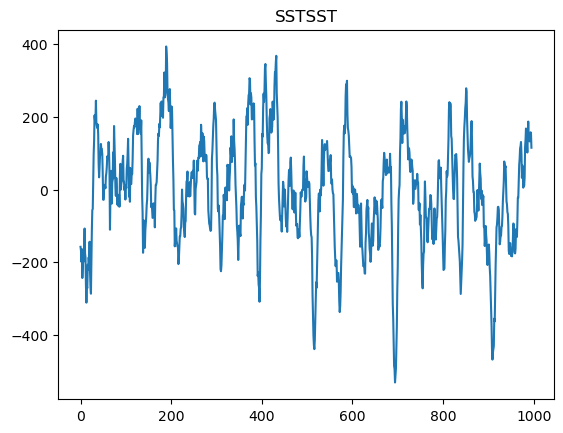

In [6]:
#Verification variables data base
# SSTver = zaic.Field('SST',['SST'],'TROPIC',math.inf)

# ver_dict = {'period':'ANN', 'version':'V5', 'SMOOTH':SMOOTH, 'normalization':normalization, \
#                    'shift':'ERA5', 'case':case, 'datatype':'Target_data','location':homedir+dddir}
# #Save space
# VEX=zai.make_data_base([SSTver], **ver_dict)
plt.plot(INX[Score_Field]['vdat'][0,:])
plt.title(Score_Field)
plt.show()

In [7]:
# Obtain time dates from data chosen
field1 = Score_Field
fd = INX[field1]['X'].A.time.data[0]
fl = INX[field1]['X'].A.time.data[-1]
pd.Timestamp(fd), pd.Timestamp(fl)
data_time = pd.date_range(start=fd, end=fl, freq='1MS')
data_time_str = data_time.strftime('%Y-%m-%d')

In [8]:
# Configure AI Model
# Find total number of features and boundaries
num_features_src, m_lim_src = zai.make_features(INX) 
# Find total of features in target
num_features_tgt, m_lim_tgt = zai.make_features(PDX) 


Processing field SST that is Source_data
Limit for SST is 15

Processing field U that is Source_data
Limit for U is 25
Total number of features  40

Processing field SST that is Source_data
Limit for SST is 15

Processing field U that is Source_data
Limit for U is 25
Total number of features  40


In [ ]:
params = {
    'TIN': 48,                          # Time Input length: number of historical time steps fed to encoder
    'MIN': num_features_src,            # Number of input features from source variables
    'T': 12,                            # Deprecated/unused time parameter (kept for compatibility)
    'K': num_features_tgt,              # Number of target/output features to predict
    'EPOCHS': 400,                      # Number of training epochs
    'RESTART': False,                   # Whether to restart training from scratch (vs. resuming)
    'D_DIM': 256,                       # Model dimension (embedding/hidden dimension for transformer)
    'Tpredict': 12,                     # Prediction horizon: number of future time steps to forecast
    'FFN_DIM': 256,                     # Feed-forward network dimension in transformer layers
    'ENC_Heads': 8,                     # Number of attention heads in encoder
    'DEC_Heads': 8,                     # Number of attention heads in decoder
    'enc_dec_layers': 2,                # Number of encoder and decoder layers
    'scaling': 'MaxMin',                # Input scaling method: MaxMin for min-max scaling
    'LR': 1*0.00005,                    # Learning rate for optimizer (5e-5)
    'WD': 0.01,                         # Weight decay (L2 regularization) for optimizer
    'savefile': None                    # File path to save trained model (set below)
}
# Construct model save filename based on configuration parameters
params['savefile'] = f"informer_{case}_{normalization}_{params['enc_dec_layers']}_{params['D_DIM']}_{params['TIN']}_{SMOOTH}"
# Discount factor for regularization or loss weighting (0.9 = slight discount on earlier predictions)
params['discount'] = 0.9  #1.0#0.9
subcase = 1
subcase_var = 100

TIN = params['TIN']  # Number of input timestep47
MIN = params['MIN']   # Number of input features
T = params['T']    # Number of output timesteps
K = params['K']    # Number of predicted features
num_epochs = params['EPOCHS'] 
RESTART = params['RESTART']
Tpredict = params['Tpredict']
LAGS =[1,2,3,4]

params['lags'] = LAGS
CONTEXT = TIN - max(LAGS)
assert CONTEXT > 0, 'Value of LAGS wrong'
print(f' Chosen context is {CONTEXT}, for max(lags)  {max(LAGS)}')

learning_rate = params['LR'] 
file = 'MOD_' + params['savefile'] + '.pt'
FIGfile =  'FIG_' + params['savefile'] + '.pdf'

batch_size = 16
# Reproducibility
torch.manual_seed(17553984)

match choose_device:
    case 'CPU':
        device = torch.device('cpu')
        t_type = torch.float32
    case 'MPS':
        device = torch.device('mps')
        t_type = torch.float32
    case _:
        device = torch.device('cpu')
        t_type = torch.float32
torch.set_default_dtype(t_type)
params['t_type'] = t_type
params['device'] = device
#
#
# The Convention for indeces is that they point to the real date.
# I python ranges need to be defined then it must take into account the extra 1
data_time.get_loc(fd)

start_date = data_time_str[0]
end_training = '2005-12-01'

start_val = '2006-01-01'
end_val = '2015-12-01'

test_start = '2016-01-01'
test_end = '2022-12-01'


# end_training = '2010-12-01'

# start_val = '2011-01-01'
# end_val = '2016-12-01'

# test_start = '2017-01-01'
# test_end = '2022-12-01'

print(f'Training \tfrom \t{start_date} \tto \t{end_training} \nValidation \tfrom \t{start_val} \tto \t{end_val} \nTesting \tfrom \t{test_start} \tto \t{test_end}\n')

train_period_start = data_time.get_loc(start_date)
train_period_end = data_time.get_loc(end_training)
val_period_start = data_time.get_loc(start_val)
val_period_end = data_time.get_loc(end_val)
test_period_start = data_time.get_loc(test_start)
test_period_end = data_time.get_loc(test_end)

params |= {'start_date':start_date,'end_training':end_training, 'start_val':start_val,'end_val':end_val,'test_start':test_start,'test_end':test_end, \
        'train_period_start':train_period_start,'train_period_end':train_period_end, 'val_period_start':val_period_start, 'val_period_end':val_period_end,'test_period_start':test_period_start, 'test_period_end':test_period_end}


print(f'Absolute Indices for \nTraining \t{train_period_start}\tto \t{train_period_end}\nValidation \t{val_period_start}\tto \t{val_period_end}\nTest \t\t{test_period_start}\tto \t{test_period_end}\n')
print(f'Range Indices for \nTraining \t{train_period_start}\tto \t{train_period_end+1}\nValidation \t{val_period_start}\tto \t{val_period_end+1}\nTest \t\t{test_period_start}\tto \t{test_period_end+1}\n')


print(f'Data Extent in Training {(train_period_end-train_period_start)+1}')
print(f'Data Extent in Validation {(val_period_end-val_period_start)+1}')
print(f'Data Extent in Test {(test_period_end-test_period_start)+1}')


# Define range indices for forecasting sequences
params['train_first_fcs'] = TIN                           # First forecasted month for first forecast 
params['train_last_fcs'] = params['train_period_end'] - Tpredict   + 1     # First forecasted month for last forecast 
params['val_first_fcs'] = params['val_period_start']  + TIN    
params['val_last_fcs'] = params['val_period_end'] - Tpredict    + 1   
params['test_first_fcs'] = params['test_period_start']  + TIN
params['test_last_fcs'] = params['test_period_end'] - Tpredict    + 1    
print(f'Starting indices for the sequences in training and forecasts\n')
print(f"TESTING -- \tFirst forecasted month for first forecast {params['test_first_fcs']} \t--> {data_time[params['test_first_fcs']]}\
                    \n\t\tFirst forecasted month for last forecast {params['test_last_fcs']} \t--> {data_time[params['test_last_fcs']]}")
print(f"TRAINING -- \tFirst forecasted month for first forecast {TIN}\t--> {data_time[TIN]}\
                    \n\t\tFirst forecasted month for last forecast {params['train_last_fcs']}\t--> {data_time[params['train_last_fcs']]}")

print(f'Number of forecast cases in each epoch')
print(f"Forecast in Training {params['train_last_fcs']-params['train_first_fcs'] +1 }")
print(f"Forecast in Validation {params['val_last_fcs']-params['val_first_fcs'] +1 }")
print(f"Forecast in Test {params['test_last_fcs']-params['test_first_fcs'] +1 }")

 Chosen context is 44, for max(lags)  4
Training 	from 	1940-01-01 	to 	2005-12-01 
Validation 	from 	2006-01-01 	to 	2015-12-01 
Testing 	from 	2016-01-01 	to 	2022-12-01

Absolute Indices for 
Training 	0	to 	791
Validation 	792	to 	911
Test 		912	to 	995

Range Indices for 
Training 	0	to 	792
Validation 	792	to 	912
Test 		912	to 	996

Data Extent in Training 792
Data Extent in Validation 120
Data Extent in Test 84
Starting indices for the sequences in training and forecasts

TESTING -- 	First forecasted month for first forecast 960 	--> 2020-01-01 00:00:00                    
		First forecasted month for last forecast 984 	--> 2022-01-01 00:00:00
TRAINING -- 	First forecasted month for first forecast 48	--> 1944-01-01 00:00:00                    
		First forecasted month for last forecast 780	--> 2005-01-01 00:00:00
Number of forecast cases in each epoch
Forecast in Training 733
Forecast in Validation 61
Forecast in Test 25


### Section 2: Model Architecture Configuration

This section configures the Informer model hyperparameters and temporal data partitioning.

#### Key Model Parameters:
- **TIN (Time Input)**: 48 months of historical context fed to encoder
- **Tpredict**: 12 months prediction horizon
- **D_DIM**: 256 (model embedding dimension)
- **ENC_Heads/DEC_Heads**: 8 attention heads per layer
- **enc_dec_layers**: 2 stacked encoder/decoder layers
- **Learning Rate**: 5e-5 with adaptive scheduling
- **Discount Factor**: 0.9 (weights recent predictions higher)

#### Temporal Partitioning:
- **Training**: 1940-01-01 to 2005-12-01 (66 years)
- **Validation**: 2006-01-01 to 2015-12-01 (10 years)
- **Testing**: 2016-01-01 to 2022-12-01 (7 years)

**Important Note**: Time boundaries are absolute calendar limits and do NOT account for input sequence length (TIN) or prediction lead time (Tpredict). These are handled internally during data loader construction to ensure no data leakage.

## Section 3: Data Preparation and Visualization

This section prepares the data for model ingestion by:
1. Extracting temporal features (month, quarter, year information)
2. Creating lagged sequences with specified lag structure [1,2,3,4]
3. Constructing train/validation/test data loaders with temporal integrity
4. Visualizing input data patterns and feature distributions

In [10]:
 zai.transform_strings(k for k in INX.keys() if 'X' in INX[k].keys())

['SST']

SSTSST
 Opening figure , 1 rows and 1 cols 

Ten Contours automatic


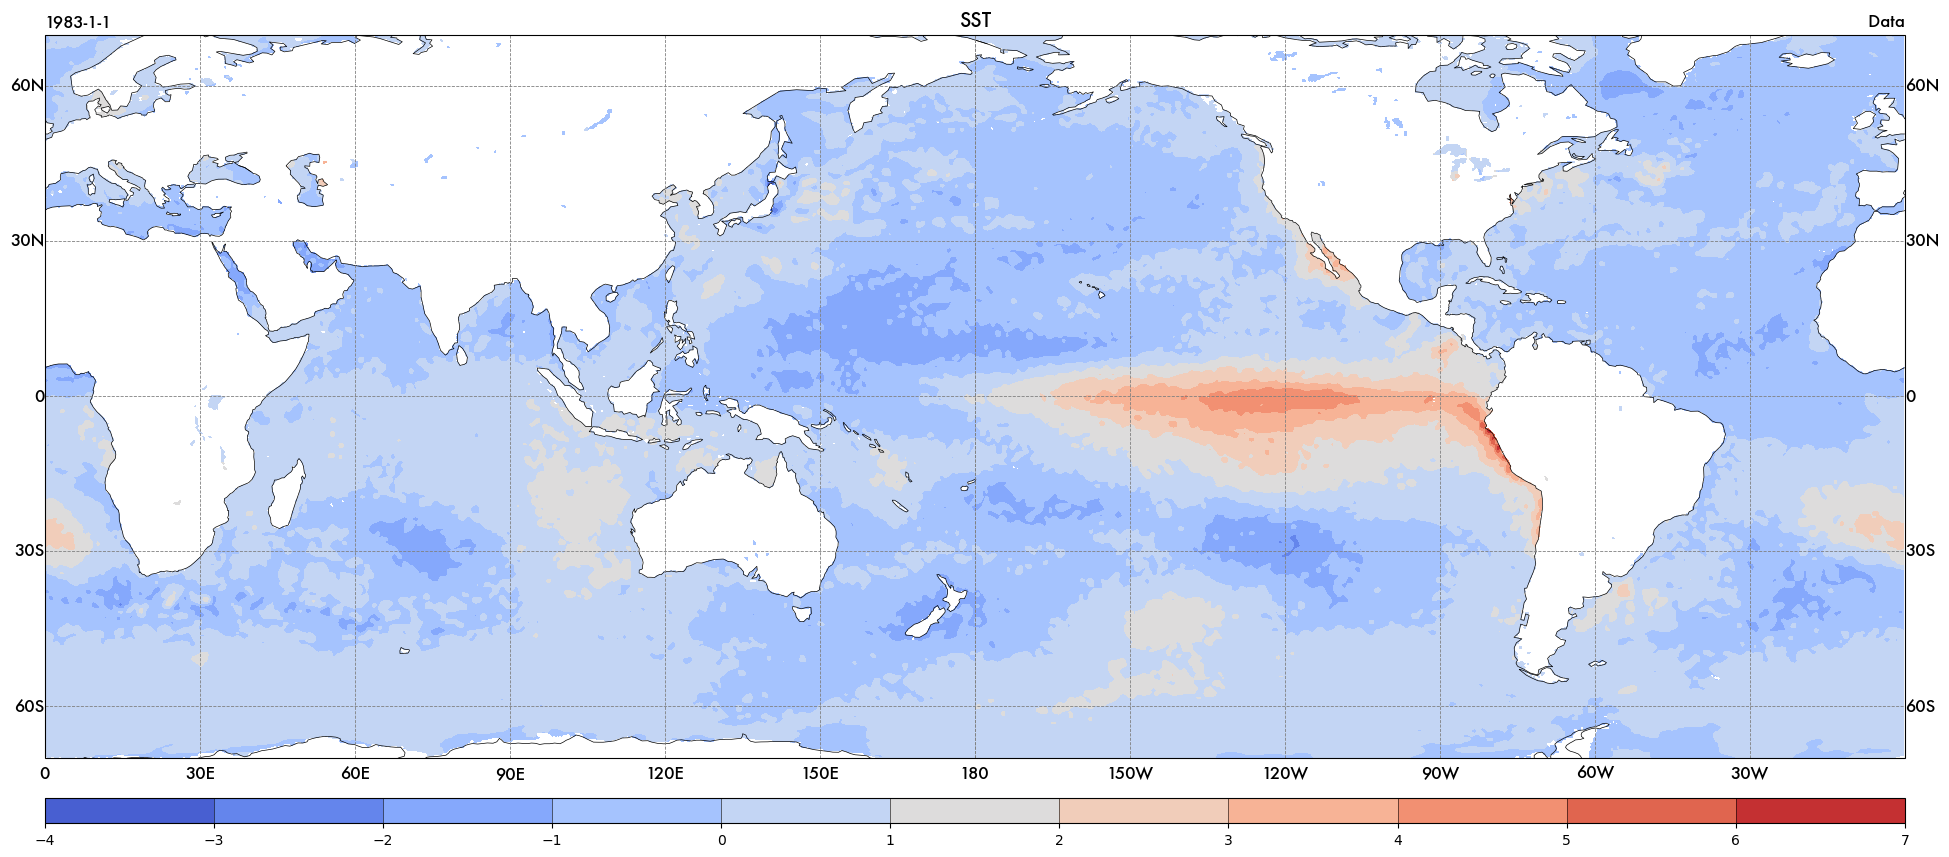

In [11]:
slim=4.0
cont1=[-slim,slim,0.5]
cont2=[-slim,slim,0.5]
cont1=[]
cont2=[]
cont3=[]
label1 = ' Data'
label2 = '1983-1-1'
label3 = '1998-1-1'

# Filter the keys to only include those that contain 'X'
inx_keys =  [k for k in INX.keys() if 'X' in INX[k].keys() ]
print(inx_keys[0])
# Initialize the figure with the number of filtered keys
fig, ax, pro = zmap.init_figure(len(inx_keys), 1, 'Pacific', constrained_layout=False, figsize=(24,12))

# Loop over the filtered keys
for i, key in enumerate(inx_keys):
    X, arealat, arealon, centlon = zai.select_field(INX, key)
   
    # Use a single axis if there's only one, otherwise use the corresponding subplot
    axm = ax if len(inx_keys) < 2 else ax[i]
    
    handle = zmap.xmap(
        X.A.sel(time=label2).unstack(), cont1, pro,
        ax=axm,
        refline=None,
        c_format='{:4.2f}',
        data_cent_lon=centlon,
        xlimit=(arealon[0], arealon[1]),
        ylimit=(arealat[1], arealat[0]),
        title={'maintitle': zai.transform_strings([key])[0], 'lefttitle': label2, 'righttitle': label1},
        cmap='coolwarm',
        contour=False
    )
    
    zmap.add_colorbar(fig, handle['filled'], axm, label_size=10, edges=True)

# Adjust the subplots and save the figure
fig.subplots_adjust(wspace=0.1, hspace=0.3)
labfile = f'{data_name}SST{period}.pdf'
plt.savefig(labfile, orientation='landscape', format='pdf')
plt.show()

### Data Loading for Prediction

Prepare test data loaders using the `TimeSeriesFuture` class which constructs sequences with:
- Input sequence length: 48 months (TIN)
- Prediction lead time: 12 months (Tpredict)
- Temporal features: Month indicators, seasonality information

SST (15,) (15, 996)
U (25,) (25, 996)


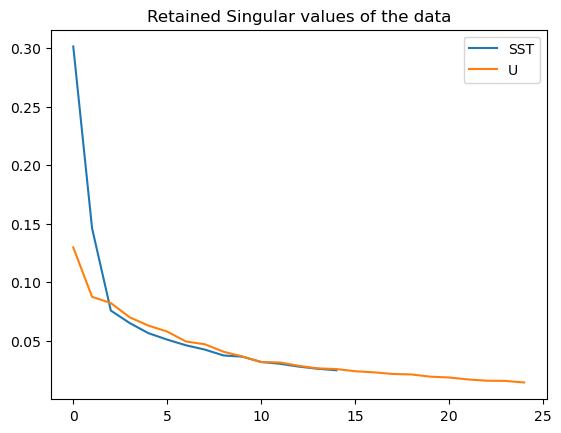

In [12]:
for i in INX.keys():
    print(INX[i]['field'],INX[i]['sdat'].shape,INX[i]['vdat'].shape)
    plt.plot(INX[i]['sdat']**2/sum(INX[i]['sdat']**2),label=INX[i]['field'])

plt.legend()
plt.title('Retained Singular values of the data')
plt.show()

select_field_eof ---> Extracting EOF data for SST
 Opening figure , 2 rows and 1 cols 

Ten Contours automatic
Ten Contours automatic


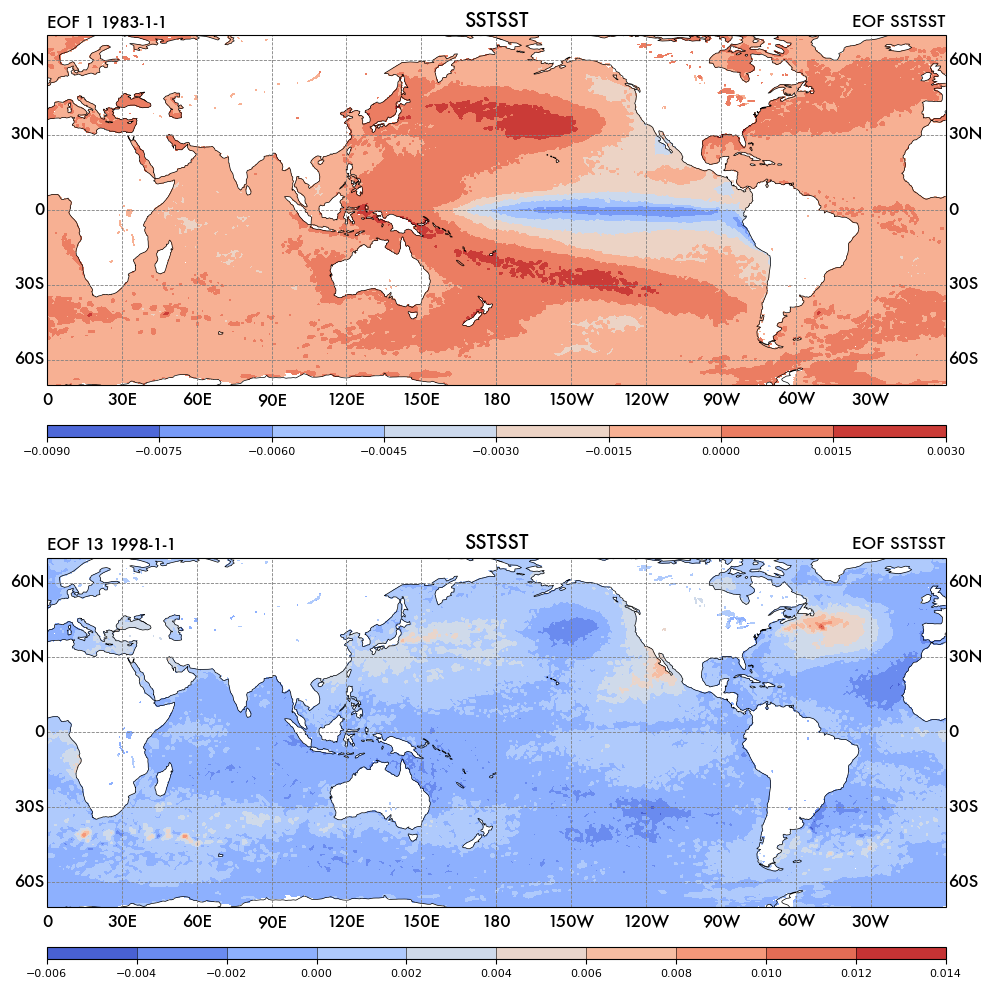

In [13]:
#Plot first EOF of input fields
plfield = Score_Field
Nplfield = INX[plfield]['mr']
udat,_,_ = zai.select_field_eof(INX,plfield)
nameeof = zai.select_field_key(INX,plfield,'field')+zai.select_field_key(INX,plfield,'level')
utest = INX[plfield]['X'].A.isel(time=slice(0,Nplfield)).copy(data=udat[:,0:Nplfield])
arealon = zai.select_field_key(INX,plfield,'arealon')
arealat = zai.select_field_key(INX,plfield,'arealat')
plpro = 'Pacific'
if INX[plfield]['area'] == 'EUROPE':
    plpro = 'Atlantic'
slim=4.0
cont1=[-slim,slim,0.5]
cont2=[-slim,slim,0.5]
cont1=[]
cont2=[]
label1 = 'EOF ' + nameeof
label2 = f'EOF 1 1983-1-1'
label3 = f'EOF {Nplfield-2} 1998-1-1'
    
fig,ax,pro=zmap.init_figure(2,1,plpro, constrained_layout=False, figsize=(12,12) )
handle=zmap.xmap(utest.isel(time=0).unstack(),cont1, pro, ax=ax[0],refline=None, c_format='{:4.2f}',data_cent_lon=INX[plfield]['centlon'],\
                       xlimit=(arealon[0],arealon[1]), ylimit=(arealat[1],arealat[0]),
                 title={'maintitle':Score_Field, 'lefttitle':label2,'righttitle':label1},cmap='coolwarm',contour=False)
zmap.add_colorbar(fig, handle['filled'], ax[0], label_size=8,edges=True)
# ax[1].projection = zmap.choose_projection('Atlantic')
han1=zmap.xmap(utest.isel(time=Nplfield-2).unstack(), cont2, plpro, ax=ax[1], refline=None,c_format='{:4.2f}',data_cent_lon=INX[plfield]['centlon'],\
                       xlimit=(arealon[0],arealon[1]),ylimit=(arealat[1],arealat[0]),
               title={'maintitle':Score_Field, 'lefttitle':label3,'righttitle':label1},cmap='coolwarm',contour=False)
zmap.add_colorbar(fig, han1['filled'], ax[1],label_size=8,edges=True)
fig.subplots_adjust(wspace=0.1,hspace=0.3)
labfile =  f'EOF{data_name}SST{period}.pdf'
# plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show()

### Feature Dimensionality Summary

Display the model's feature size and input dimension for verification.

In [14]:
# Configure AI Model
# Find total number of features and boundaries
num_features_src, m_lim_src = zai.make_features(INX) 
# Find total of features in target
num_features_tgt, m_lim_tgt = zai.make_features(PDX) 


Processing field SST that is Source_data
Limit for SST is 15

Processing field U that is Source_data
Limit for U is 25
Total number of features  40

Processing field SST that is Source_data
Limit for SST is 15

Processing field U that is Source_data
Limit for U is 25
Total number of features  40


# Configure the model

## Define Time limit taking into account Tpredict and predictions

The model can have two different future times. *T*  is the time on which the model is trained. The second time is Tpredict. This is the extent of the prediction that is going to be produced by the greedy inference after the model is being evaluated.

The prediction starting time can go only to Tpredict distance from the end training.
And the first forecast start at time *start_test + TIN*


In [15]:

# Split the dataset into train, validation, and test sets
train_size = (train_period_end-train_period_start)+1
val_size = (val_period_end-val_period_start)+1
test_size = (test_period_end-test_period_start)+1

tot_size = (test_period_end-train_period_start)+1
print(f'Train {train_size}, Validation {val_size}, Test {test_size}')
print(f'Check {train_size+val_size+test_size} <---> {tot_size}')

# Split the data into train, validation, and test sets
train_data, val_data, test_data, _ = zai.make_data(INX,params)
tgt_train_data, tgt_val_data, tgt_test_data, _ = zai.make_data(PDX,params)    

#Optionally use differences
if comp_diff:
    train_data, trIC = zai.compute_increments(train_data,axis=0)
    val_data, vaIC = zai.compute_increments(val_data,axis=0)
    test_data, teIC = zai.compute_increments(test_data,axis=0)
    tgt_train_data, _ = zai.compute_increments(tgt_train_data,axis=0)
    tgt_val_data, _ = zai.compute_increments(tgt_val_data,axis=0)
    tgt_test_data, _ = zai.compute_increments(tgt_test_data,axis=0)


print(f'\nTensors Train {train_data.shape}, Validation {val_data.shape}, Test {test_data.shape}')
print(f'Check Tensors {train_data.shape[0]+val_data.shape[0]+test_data.shape[0]}')



Train 792, Validation 120, Test 84
Check 996 <---> 996

Processing field SST that is Source_data
select_field_eof ---> Extracting EOF data for SST
vdat (15, 996)
Using MaxMin scaling
Added field SSTSST to feature input data
Index for field SST are 0 and 15

Using MaxMin scaling
Using  15  EOFs for 0.5444724584435908 variance retained

Processing field U that is Source_data
select_field_eof ---> Extracting EOF data for U
vdat (25, 996)
Using MaxMin scaling
Added field U850 to feature input data
Index for field U are 15 and 40

Using MaxMin scaling
Using  25  EOFs for 0.624805470833808 variance retained
Training data shape torch.Size([792, 40])
Validation data shape torch.Size([120, 40])
Testing data shape torch.Size([84, 40])

Processing field SST that is Source_data
select_field_eof ---> Extracting EOF data for SST
vdat (15, 996)
Using MaxMin scaling
Added field SSTSST to feature input data
Index for field SST are 0 and 15

Using MaxMin scaling
Using  15  EOFs for 0.5444724584435908 va

In [16]:
# Create instances of the time features
tim_train = zai.create_time_features(data_time[:train_size+1], 0, device)
tim_val = zai.create_time_features(data_time[train_size:train_size+val_size+1], 0, device)
tim_test = zai.create_time_features(data_time[train_size+val_size:tot_size+1], 0, device)

# Create instances of the custom dataset for train, validation, and test
train_dataset = zcf.TimeSeriesDataset(train_data, tgt_train_data, TIN, MIN, T, K, time_features=tim_train )
val_dataset = zcf.TimeSeriesDataset(val_data, tgt_val_data, TIN, MIN, T, K, time_features=tim_val )
test_dataset = zcf.TimeSeriesDataset(test_data, tgt_test_data,TIN, MIN, T, K, time_features=tim_test )

# Create data loaders for train, validation, and test sets
train_dataloader = DataLoader(train_dataset,  batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size)

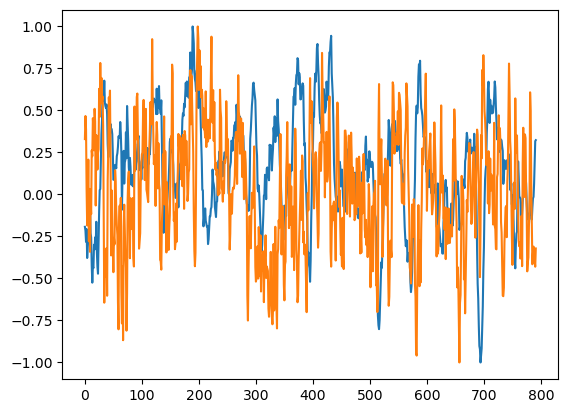

In [17]:

#Create dataloader configuration for prediction
# Only for the test dataset
# Create instances of the custom dataset for train, validation, and test
# pred_dataset = zaic.TimeSeriesDataset(test_data, tgt_test_data, tim_test,TIN, MIN, Tpredict, K)

# # Create data loaders for train, validation, and test sets
# pred_dataloader = DataLoader(pred_dataset,batch_size=batch_size)
plt.plot(train_data[:,0].cpu().numpy())
plt.plot(train_data[:,11].cpu().numpy())
plt.show()


## Section 5: Model Inference and Post-Processing

Generate predictions on train/validation/test sets and rescale outputs back to physical units.

In [18]:
# Initializing an Informer configuration with 12 time steps for prediction
# loss_weight can be defined for the loss function as a tensor (batch_size, T), with weights summing to 1
configuration = ctr.InformerConfig(prediction_length=T, context_length = CONTEXT, 
                distribution_output = 'student_t', loss = 'nll', 
                input_seq = TIN,
                input_size = num_features_src,
                output_size = num_features_tgt,
                lags_sequence = LAGS,
                scaling = 'std',
                num_dynamic_real_features = 0, 
                num_static_real_features = 0,
                num_static_categorical_features = 0,
                num_time_features  = 3,
                cardinality = None,
                embedding_dimension=None,
                pos_embedding_dim = None, 
                d_model= params['D_DIM'],
                encoder_ffn_dim = params['FFN_DIM'],
                decoder_ffn_dim = params['FFN_DIM'],
                encoder_attention_heads = params['ENC_Heads'],
                decoder_attention_heads = params['DEC_Heads'],
                encoder_layers = params['enc_dec_layers'],
                decoder_layers = params['enc_dec_layers'],
                output_hidden_states = True,
                is_encoder_decoder = True,
                activation_function = 'relu',
                dropout = 0.2,
                encoder_layerdrop = 0.0,
                decoder_layerdrop= 0.0,
                attention_dropout= 0.1,
                activation_dropout= 0.1,
                num_parallel_samples= 50,
                init_std = 0.02,
                use_cache = True,
                attention_type= 'full',
                sampling_factor = 5,
                discount = params['discount'],
                Tpredict = Tpredict,
                distil = False)

# Set random seed
torch.manual_seed(17553984)

# Randomly initializing a model (with random weights) from the configuration
# model = zcf.ClimFormer(configuration)
model = ltr.InformerForPrediction(configuration)
# 
# Accessing the model configuration
configuration = model.config

configuration.context_length

44

## Section 4: Model Training and Validation

This section implements the training loop with:
- **Multiple Optimizers**: Adam (learning rate 1e-4) and AdamW (5e-5) with weight decay
- **Learning Rate Scheduling**: ReduceLROnPlateau with patience=5, factor=0.5
- **Early Stopping**: Patience=10 epochs without validation improvement
- **Gradient Clipping**: Norm=1.0 to prevent exploding gradients
- **Loss Function**: Negative Log-Likelihood for probabilistic forecasting
- **Batch Size**: 16 samples
- **Checkpointing**: Best model saved based on validation loss

The model is trained on GPU/MPS device with automatic precision management.

In [19]:
configuration.feature_size

243

In [20]:
# Discounting 
print(f'Discounting set at {[configuration.discount**i for i in range(Tpredict+1)]}')


Discounting set at [1.0, 0.9, 0.81, 0.7290000000000001, 0.6561, 0.5904900000000001, 0.531441, 0.4782969000000001, 0.4304672100000001, 0.3874204890000001, 0.3486784401000001, 0.31381059609000006, 0.2824295364810001]


In [21]:
# criterion = nn.L1Loss()

#Optimizer
optim1 = optim.Adam(model.parameters(),lr=2*learning_rate,weight_decay=params['WD'],amsgrad=True)
# optim1 = torch.optim.SGD(model.parameters(), lr=2*learning_rate, momentum=0.8)
# optim3 = torch.optim.SGD(model.parameters(), lr=2*learning_rate, momentum=0.5)
optim2 = optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=params['WD'],amsgrad=True)
# optim4 = optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=params['WD'])

criterion = None
#Number of parameters
print(f'The model has {zai.count_parameters(model):,} trainable parameters')
model

The model has 2,266,744 trainable parameters


InformerForPrediction(
  (model): InformerModel(
    (scaler): InformerStdScaler()
    (encoder): InformerEncoder(
      (value_embedding): InformerValueEmbedding(
        (value_projection): Linear(in_features=243, out_features=256, bias=False)
      )
      (embed_positions): InformerSinusoidalPositionalEmbedding(56, 256)
      (layers): ModuleList(
        (0-1): 2 x InformerEncoderLayer(
          (self_attn): InformerAttention(
            (k_proj): Linear(in_features=256, out_features=256, bias=True)
            (v_proj): Linear(in_features=256, out_features=256, bias=True)
            (q_proj): Linear(in_features=256, out_features=256, bias=True)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=256, out_features=256, bias=True)
          (fc2): Linear(in_features=256, out_features=256

In [22]:
%%time
# train and validate model
clip=1
check_val = 1
patience=10

if RESTART:
    model.load_state_dict(torch.load(file))
else:
    import subprocess
    subprocess.run(["rm", "*.pt"])
    print("All *.pt files removed")
    
best_val_loss = float("inf")
num_epochs = params['EPOCHS']
loss_tr = []
loss_va = []

optims = [ optim1, optim2]
rates = [learning_rate, learning_rate, learning_rate]

for i in range(len(optims)):    

    print(optims[i])
    early_stopping = zaic.EarlyStopping(patience=patience, verbose=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optims[i], patience=patience/2, factor=0.5, mode="min")
    for epoch in range(num_epochs):

        model.to(device)

        # Train the model
        trained_model,losstr = mtr.train_model(model, epoch,  train_dataloader, optims[i],
                                lr=rates[i], patience=patience, clip=1.0,device=device,criterion=criterion)
        loss_tr.append(losstr)
        if epoch % check_val == 0:
            trained_model,lossva = mtr.validate_model(model, epoch,  val_dataloader, 
                                lr=rates[i], patience=patience, clip=1.0,device=device,criterion=criterion)
           
            loss_va.append(lossva)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            scheduler.step(lossva)
            print(f' Scheduler learning rate: {scheduler.get_last_lr()}')
            # Early stopping
            if early_stopping(lossva):
                print(f"Early stopping at epoch {epoch + 1}")
                break

            if lossva < best_val_loss:
                best_val_loss = lossva
                print(f'Saving file to {file} at loss {lossva:.5f}')
                torch.save(model.state_dict(), file)

            if epoch % 2 == 0:
                print(f'\t Epoch {epoch} --   Train Loss: {losstr:.5f} --- Valid Loss: {lossva:.5f}')

            
    # Load the best model
    model.load_state_dict(torch.load(file))

All *.pt files removed
Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)


rm: *.pt: No such file or directory


 Scheduler learning rate: [0.0001]
Saving file to MOD_informer_Y620d_anom_2_256_48_False.pt at loss 7.93675
	 Epoch 0 --   Train Loss: 12.57654 --- Valid Loss: 7.93675
 Scheduler learning rate: [0.0001]
Saving file to MOD_informer_Y620d_anom_2_256_48_False.pt at loss 7.68981
 Scheduler learning rate: [0.0001]
Saving file to MOD_informer_Y620d_anom_2_256_48_False.pt at loss 7.50686
	 Epoch 2 --   Train Loss: 10.40170 --- Valid Loss: 7.50686
 Scheduler learning rate: [0.0001]
Saving file to MOD_informer_Y620d_anom_2_256_48_False.pt at loss 7.32110
 Scheduler learning rate: [0.0001]
Saving file to MOD_informer_Y620d_anom_2_256_48_False.pt at loss 7.09706
	 Epoch 4 --   Train Loss: 8.57284 --- Valid Loss: 7.09706
 Scheduler learning rate: [0.0001]
Saving file to MOD_informer_Y620d_anom_2_256_48_False.pt at loss 6.86450
 Scheduler learning rate: [0.0001]
Saving file to MOD_informer_Y620d_anom_2_256_48_False.pt at loss 6.62654
	 Epoch 6 --   Train Loss: 6.34425 --- Valid Loss: 6.62654
 Sched

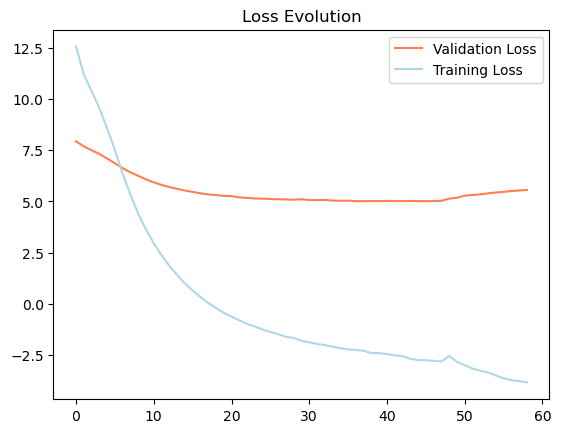

In [23]:
plt.plot(loss_va,color='coral',label='Validation Loss')
plt.plot(loss_tr,color='lightblue',label='Training Loss')
plt.legend()
plt.title('Loss Evolution')
plt.show()

In [24]:
#Create data loaders for prediction with Tpredict length for the future features
# Create instances of the custom dataset for train, validation, and test

train_dataset_fut= zcf.TimeSeriesFuture(train_data, tgt_train_data, TIN, MIN, T, K, Tpredict, time_features=tim_train )
val_dataset_fut = zcf.TimeSeriesFuture(val_data, tgt_val_data, TIN, MIN, T, K, Tpredict, time_features=tim_val )
test_dataset_fut = zcf.TimeSeriesFuture(test_data, tgt_test_data,TIN, MIN, T, K, Tpredict, time_features=tim_test )

# Create data loaders for train, validation, and test sets
train_dataloader_fut = DataLoader(train_dataset_fut,  batch_size=batch_size)
val_dataloader_fut = DataLoader(val_dataset_fut, batch_size=batch_size)
test_dataloader_fut = DataLoader(test_dataset_fut,batch_size=batch_size)

In [ ]:
### Prediction and Rescaling

This section generates deterministic forecasts by:
1. Running the trained Informer model on all data splits (train/val/test)
2. Averaging ensemble predictions (if probabilistic) to get mean forecast
3. Optionally integrating differences if model predicted anomalies
4. Rescaling predictions from normalized space back to physical units using stored scaling factors

In [25]:
#Creates Plots
model.to(device)
model.load_state_dict(torch.load(file))

out_test = mtr.predict( model, test_dataloader_fut,Tpredict, device=device,inference=None,show_progress=False).cpu().mean(axis=1)
out_val = mtr.predict( model, val_dataloader_fut,Tpredict,device=device,inference=None,show_progress=False).cpu().mean(axis=1)
out_train = mtr.predict( model, train_dataloader_fut,Tpredict,device=device,inference=None,show_progress=False).cpu().mean(axis=1)

if comp_diff:
    out_train = zai.cumsum_with_init(out_train, trIC.cpu())
    out_val = zai.cumsum_with_init(out_val, vaIC.cpu())
    out_test = zai.cumsum_with_init(out_test, teIC.cpu())

out_test = out_test.cpu().detach().numpy()
out_val = out_val.cpu().detach().numpy()
out_train = out_train.cpu().detach().numpy()

In [26]:
# a,b,c,d = next(iter(test_dataloader))
# len(test_dataset)


In [27]:
# for a,b,c,d in test_dataloader:
#    print(a.shape)


# testembed = zaic.FixedPositionalEmbedding(configuration.input_seq, configuration.input_size, 64).to(device)

# testembed(a)

In [28]:
indt2m= PDX[plfield]['index']
out_train_tot, out_val_tot, out_test_tot, true_tot = \
           zai.rescale(params,PDX, out_train, out_val, out_test)
            # zai.rescale(params,PDX, out_train[:,:,indt2m], out_val[:,:,indt2m], out_test[:,:,indt2m])



out_test_p = out_test_tot[...,indt2m] 
out_train_p = out_train_tot[...,indt2m] 
out_val_p = out_val_tot[...,indt2m] 
truep = true_tot[..., indt2m]


Processing field SST that is Source_data
Number of modes retained 15
(996, 15)

Processing field U that is Source_data
Number of modes retained 25
(996, 25)
(733, 12, 40)


48 780 840 900 960 984
Initial sequence of 48 months, 
	 the Training   starts at: 	1944-01-01 00:00:00
	Validation starts at: 	2010-01-01 00:00:00
	First Forecast at:	2020-01-01 00:00:00 valid until 	2020-12-01 00:00:00
	Initial Sequence from:	2016-01-01 00:00:00 (912) to	2019-12-01 00:00:00 (959)
	First IC Forecast at:	2019-12-01 00:00:00 valid until 	2020-12-01 00:00:00


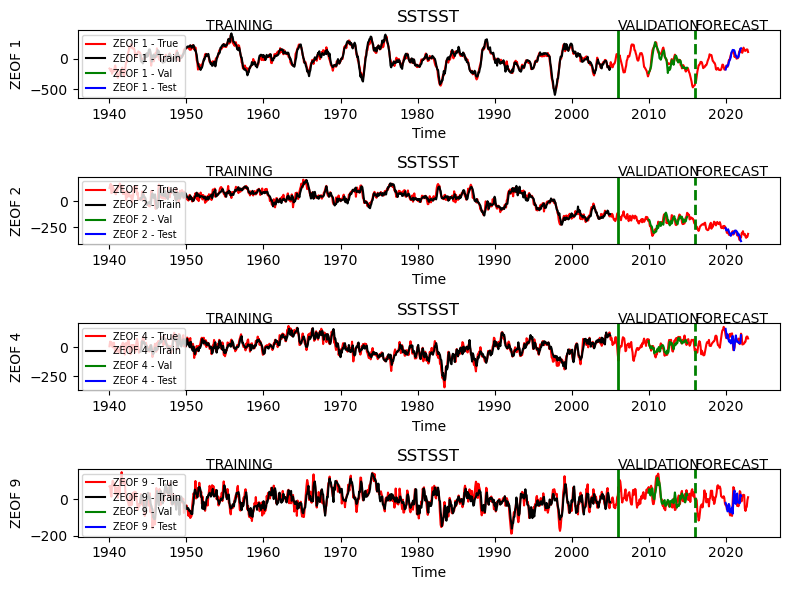

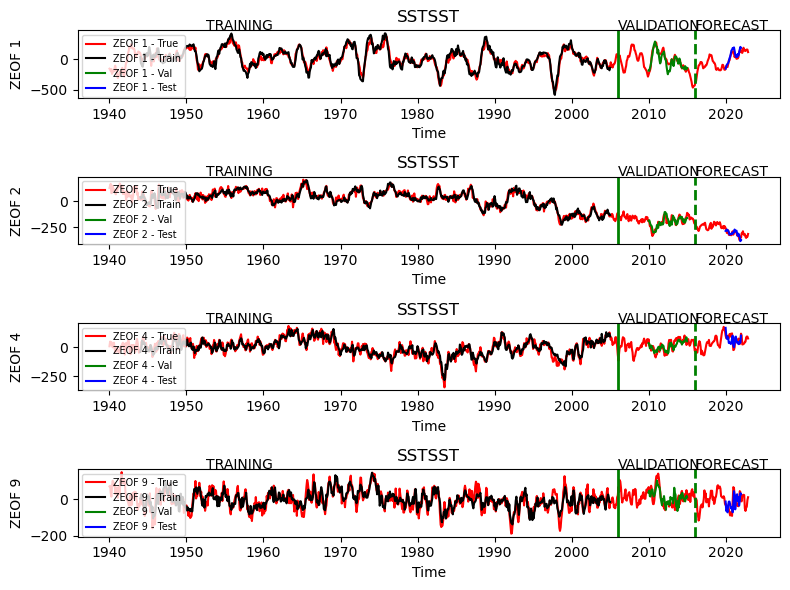

In [29]:


times = data_time
# Plot the first subplot for the month monpred
monpred = 1

starttr = params['train_first_fcs']
endtr = params['train_last_fcs']
startval = params['val_first_fcs']
endval = params['val_last_fcs']
starttest = params['test_first_fcs']
endtest = params['test_last_fcs']
print(starttr,endtr,startval,endval,starttest,endtest)
print(f'Initial sequence of {TIN} months, \n\t the Training   starts at: \t{times[starttr]}')
print(f'\tValidation starts at: \t{times[startval]}')
print(f'\tFirst Forecast at:\t{times[starttest]} valid until \t{times[starttest+Tpredict-1]}')
print(f'\tInitial Sequence from:\t{times[starttest-TIN]} ({starttest-TIN}) to\t{times[starttest-1]} ({starttest-1})')
print(f'\tFirst IC Forecast at:\t{times[starttest-1]} valid until \t{times[starttest-1+Tpredict]}')



tit =Score_Field
def plot_result(ax1,out_train,out_val,out_test,monpred,neof,leof,tit,true=None):
    
    ax1.plot(times,true[:,neof], color='red', label=leof +' - True')
    ax1.plot(times[starttr:endtr+1],out_train[:,monpred,neof], color='black', label=leof +' - Train')
    ax1.plot(times[startval:endval+1],out_val[:,monpred,neof], color='green', label=leof +' - Val')
    ax1.plot(times[starttest:endtest+1],out_test[:,monpred,neof], color='blue', label=leof +' - Test')
    # ax1.set_xlim(times[1500],times[1600])
    ax1.set_xlabel('Time')
    ax1.set_ylabel(leof)
    ax1.set_title(tit)
    ax1.axvline(times[train_size],color='green',lw=2.0)
    ax1.axvline(times[train_size+val_size],color='green',lw=2.0,linestyle='dashed')
    _, yt = ax1.get_ylim()
    ax1.text(times[150],yt+1,'TRAINING')
    ax1.text(times[train_size],yt+1,'VALIDATION')
    ax1.text(times[train_size+val_size],yt+1,'FORECAST')
    # ax1.set_xlim((times[1500],times[1600]))
    ax1.legend(loc='upper left',fontsize='x-small')
    return None
# Create a figure with two subplots
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# plot_result(ax1,out_train_S,out_val_S,out_test_S,monpred,0,'EOF 1',tit)
# plot_result(ax2,out_train_S,out_val_S,out_test_S,monpred,1,'EOF 2',tit)

# Adjust the layout to avoid overlapping labels and titles
# plt.tight_layout()

# Display the figure
# plt.show()

# Create a figure with two subplots

titz = tit
for Tp in range(2):
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(8, 6))
    plot_result(ax1,out_train_p,out_val_p,out_test_p,Tp,0,'ZEOF 1',titz,true=truep)
    plot_result(ax2,out_train_p,out_val_p,out_test_p,Tp,1,'ZEOF 2',titz,true=truep)
    plot_result(ax3,out_train_p,out_val_p,out_test_p,Tp,3,'ZEOF 4',titz,true=truep)
    plot_result(ax4,out_train_p,out_val_p,out_test_p,Tp,8,'ZEOF 9',titz,true=truep)
    # Adjust the layout to avoid overlapping labels and titles
    plt.tight_layout()
    plt.show()


In [30]:
Cont = namedtuple('Contours', 'max min int')
cont_ = Cont(4, -3, 0.5)
cont_

Contours(max=4, min=-3, int=0.5)

In [31]:
# cont = [-3, 3, 0.25]

plfield=Score_Field
arealatz = zai.select_field_key(INX,plfield,'arealat')
arealonz = zai.select_field_key(INX,plfield,'arealon')

#Fix contours for variables
Cont = namedtuple('Contours', 'max min int')
SST_cont = Cont(4, -4, 0.25)
T2M_cont = Cont(4, -4, 0.25)
Z500_cont = Cont(1200, -1200, 100.)   

print(f'Verification done on {plfield}')

Verification done on SSTSST


In [32]:
startdate = data_time[params['test_first_fcs']-1]
enddate = data_time[params['test_last_fcs']-1]
truncated_verification = INX[plfield]['mr']
F, P, Obs  = zai.eof_to_grid(Score_Field, out_test_p, startdate, enddate, INX=PDX, params=params, truncation=truncated_verification)

Verification using truncated EOFs with 15 modes
Obs from 1940-01-01T00:00:00.000000000 to 2022-12-01T00:00:00.000000000

Number of cases 25
Obs from 2019-12-01 00:00:00 to 2021-12-01 00:00:00

Forecasts for IC at 2019-12-01 00:00:00 to 2021-12-01 00:00:00 and prediction time of 12 months
Forecast shape (25, 13, 576776), 2019-12-01T00:00:00.000000000 to 2021-12-01T00:00:00.000000000
Persistence shape (25, 13, 576776), 2019-12-01T00:00:00.000000000 to 2021-12-01T00:00:00.000000000


In [33]:
Ft = zai.make_fcst_array(startdate,enddate,Tpredict+1,F)
Pt = zai.make_fcst_array(startdate,enddate,Tpredict+1,P)



Number of times 25, number of leads 13, number of features 576776
DatetimeIndex(['2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01'],
              dtype='datetime64[ns]', freq='MS')
Number of times 25, number of leads 13, number of features 576776
DatetimeIndex(['2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
        

In [34]:
Np,Nl,NumPoints  = Ft.shape
ERROR = 'L2'

corrresult = np.zeros((Tpredict+1,Np))
persistence = np.zeros((Tpredict+1,Np))
rmsres = np.zeros((Tpredict+1,Np))
rmsper = np.zeros((Tpredict+1,Np))

for idx, ic in enumerate(Ft.time):
    ftmp = zai.select_fcst(ic, Ft)
    ptmp = zai.select_fcst(ic, Pt)
    otmp = Obs.sel(time=ftmp.time)
    corrresult[:,idx] = xr.corr(otmp, ftmp, dim='z').data
    persistence[:,idx] = xr.corr(otmp, ptmp, dim='z').data
    if ERROR == 'L1':
        rmsres[:,idx] = np.sum(abs(ftmp - otmp),axis=1).data/NumPoints
        rmsper[:,idx] = np.sum(abs(otmp - ptmp),axis=1).data/NumPoints
    else:
        rmsres[:,idx] = np.sum(abs(ftmp - otmp)**2,axis=1).data/NumPoints
        rmsper[:,idx] = np.sum(abs(otmp - ptmp)**2,axis=1).data/NumPoints
    
    

In [35]:

dyn_cmcc = {'center':'cmcc','system':['3','35'], 'SST':'SST', 'T2M':'2t', 'Z500':'Z500'}

dyn_cases = [dyn_cmcc]

match Score_Field:
    case 'SSTSST':
        ver_f = INX[plfield]['field'].upper()
    case 'T2MT2M':
        ver_f = INX[plfield]['field'].upper()
    case 'Z500':
        ver_f = 'Z500'
        
# ndyn = int(endindex[0]-startindex[0]+1)
ngrid = INX[plfield]['X'].A.shape[0]
dynddr =  homedir + drop_home + '/ERA5/SEASONAL_'+ ver_f

filever = f'DYN_{ver_f}{params["TIN"]}.nc'

if verify_dyn:
    Tpredict_dyn = 6
    # DYN = zai.make_dyn_verification(ver_f,INX[plfield]['area'], dyn_cases, dynddr, times, dyn_startdate,dyn_enddate, filever) 
    DYN = zai.make_dyn_verification_new(ver_f,INX[plfield]['area'], dyn_cases, dynddr, times, filever)
    dyn_startdate = DYN.time[0]
    dyn_enddate = DYN.time[-1]
    dyn_cases[0]['dyn_startdate'] = dyn_startdate
    dyn_cases[0]['dyn_enddate'] = dyn_enddate

Verification data loaded from file DYN_SST48.nc
Verification data shape (50, 6, 807840), times 2018-11-01T00:00:00.000000000 to 2022-12-01T00:00:00.000000000


In [36]:
# Include Initial Condition
IC = Obs.sel(time=slice(startdate,enddate)).unstack().expand_dims({'lead':[0]},axis=1)
#Align GCM forecasts woth Obs
startdate = pd.to_datetime(IC.time.data)[0]
enddate = pd.to_datetime(IC.time.data)[-1]
# Shift time coordinates so that the initial condition is aligned with first month of GCM
# Forecast
DYN_CUT = DYN.sel(time=slice(zai.advance_months(startdate,n=1),zai.advance_months(enddate,n=1))).assign_coords({"time": IC.time}).unstack()
NEW_DYN = xr.concat([IC,DYN_CUT],dim='lead').stack(z=('lat','lon')).dropna(dim='z')


In [37]:
NEW_DYN = NEW_DYN.sel(lead=np.arange(min(Tpredict,Tpredict_dyn)+1))

In [38]:
# Optionally truncate also the dynamical forecast to the EOF truncation
NEW_DYN = zai.project_dyn(NEW_DYN, INX, plfield, truncation=truncated_verification)

Tpredict_dyn = len(NEW_DYN.lead)
Dt = zai.make_fcst_array(startdate,enddate,Tpredict_dyn,NEW_DYN)

Verification using truncated EOFs with 15 modes
Number of times 25, number of leads 7, number of features 807840
DatetimeIndex(['2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01'],
              dtype='datetime64[ns]', freq='MS')


In [39]:
if write_result:
    # Write forecast and verification
    case_data =  xr.Dataset({'F': F,'V': V,'P':P, 'SD':SD,'VD':VD})
    filedyn = f"RES_{params['savefile']}.nc"

    import cf_xarray as cfxr
    xr.set_options(keep_attrs=True)
    cfxr.encode_multi_index_as_compress(case_data, 'z').to_netcdf(filedyn)

In [40]:
match Score_Field:
    case 'SSTSST':
        cont_ = SST_cont
    case 'T2MT2M':
        cont_ = T2M_cont
    case 'Z500':
        cont_ = Z500_cont


np.arange(cont_.min,cont_.max,cont_.int)
cont=[cont_.min, cont_.max, cont_.int]

# utp.many_plots(  Obs,  Score_Field, Score_Field, cont, '2020-05-01', world_projection='Pacific', colorbars=False,
#                suptitle='Obs', mainlabel='', mode='time', lead=0, ncols=2, nrows=3, arealatz=arealatz, arealonz=arealonz, centlon=180,labfile=None)


In [41]:
np.arange(cont_.min,cont_.max,cont_.int)
cont=[cont_.min, cont_.max, cont_.int]

# cont = []
# if Tpredict > 1:
#     ftmp = zai.select_fcst('2020-08-01', Ft)
#     vtmp = Obs.sel(time=ftmp.time)
#     utp.Forecast_plots(ftmp, vtmp,  Score_Field, None, cont,  pictimes=[1,2,3], title='ClimFormer Verification', \
#                                   world_projection='Pacific', colorbars=False, mainlabel='', arealatz=arealatz, arealonz=arealonz, centlon=PDX[plfield]['centlon'],labfile=None)


In [42]:
dtmp = zai.select_fcst('2020-08-01', Dt)
vtmp = Obs.sel(time=dtmp.time)

# utp.Forecast_plots(dtmp, vtmp,  Score_Field, None, cont,  pictimes=[1,2,3], title='GCM Verification', \
#                               world_projection='Pacific', colorbars=False, mainlabel='', arealatz=arealatz, arealonz=arealonz, centlon=PDX[plfield]['centlon'],labfile=None)


In [43]:
if verify_dyn:
    ERROR = 'L2'
    Tpredict_dyn = len(NEW_DYN.lead)

    # The number of forecast for the dynamical list is limited to 7 months, so the number of cases must be reduced.
    number_of_dyn = len(NEW_DYN.time)

    corrdyn = np.zeros((Tpredict_dyn,number_of_dyn))
    rmsdyn = np.zeros((Tpredict_dyn,number_of_dyn))
    # Dt = zai.make_fcst_array(startdate,enddate,Tpredict_dyn,NEW_DYN)
    NumPoints = len(Dt.z)
    for idx, ic in enumerate(Dt.time):
        ftmp = zai.select_fcst(ic, Dt)#.rename({'feature':'z'})
        otmp = Obs.sel(time=ftmp.time)

        #Stack and unstack to align arrays
        ftmp1 = ftmp.unstack().stack(z=('lat','lon'))
        otmp1 = otmp.unstack().stack(z=('lat','lon'))
        # corrdyn[:,idx] = zai.align_and_compute_correlation(otmp1, ftmp1, dim='z').data
        corrdyn[:,idx] = xr.corr(otmp1, ftmp1, dim='z').data
        
        
        if ERROR == 'L1':
                rmsdyn[:,idx]= np.sum(abs(ftmp1-otmp1),axis=1).data/NumPoints
        else:
                rmsdyn[:,idx]= np.sum(abs(ftmp1-otmp1)**2,axis=1).data/NumPoints


In [44]:
# # Extract 20 initial conditions starting from 2000-02-01, with 10 leads each
# obs_leads = construct_obs_leads(obs, n_leads=10, 
#                                 ic0=np.datetime64('2000-02-01'),
#                                 n_init_conditions=20)

# # Or extract as many as possible from a starting date
# obs_leads = construct_obs_leads(obs, n_leads=10, 
#                                 ic0=np.datetime64('2000-02-01'))

# # Default behavior (start from beginning)
# obs_leads = construct_obs_leads(obs, n_leads=10)
#Dt.sel(lead=0).unstack().isel(lat=300,lon=180)

In [45]:
# from AIModels.obs_lead_constructor import construct_obs_leads

# obs shape: (100, 1000) - 100 time steps, 1000 grid points
obs_leads = val.construct_obs_leads(Obs.unstack(), n_leads=7, ic0=Dt.time[0].data,n_init_conditions=25)
# Ds Forecasts
mobs_leads = val.construct_obs_leads(Obs.unstack(), n_leads=13, ic0=Ft.time[0].data,n_init_conditions=25)


In [46]:
DDt= Dt.unstack().stack(z=('lat','lon'))
DObs = obs_leads.stack(z=('lat','lon'))
DPt = Pt.sel(time=Dt.time,lead=slice(0,6)).unstack().stack(z=('lat','lon'))

In [47]:
# Eliminate small differencesa in IC
DDt[:,0,:] = DObs[:,0,:]

# Now compute RPSS

In [48]:
# Compute RPSS for dynamical forecasts
rpss_results_dyn = val.compute_rpss_dyn(DDt, DObs,DPt, verbose=True, device=device,leave_one_out=True)

Lead 00: RPSS(area)= 1.0000 | BSS(area) p1= 1.0000, p2= 1.0000, p3= 1.0000
Lead 01: RPSS(area)=-0.3384 | BSS(area) p1=-0.5136, p2=-0.0186, p3=-0.1575
Lead 02: RPSS(area)=-0.0332 | BSS(area) p1=-0.1289, p2= 0.1101, p3= 0.0674
Lead 03: RPSS(area)= 0.0842 | BSS(area) p1=-0.0142, p2= 0.1193, p3= 0.1867
Lead 04: RPSS(area)= 0.1582 | BSS(area) p1= 0.0564, p2= 0.0999, p3= 0.2627
Lead 05: RPSS(area)= 0.2028 | BSS(area) p1= 0.1024, p2= 0.0387, p3= 0.3036
Lead 06: RPSS(area)= 0.1881 | BSS(area) p1= 0.0837, p2= 0.0284, p3= 0.2889


In [49]:
# Compute RPSS using the refactored function from RPSS module
MObs = mobs_leads.stack(z=('lat','lon'))
rpss_results = val.compute_rpss_by_lead(Ft.unstack().stack(z=('lat','lon')), Pt.unstack().stack(z=('lat','lon')), MObs, verbose=True,device=device,leave_one_out=True)


Lead 00: RPSS(area)= 1.0000 | BSS(area) p1= 1.0000, p2= 1.0000, p3= 1.0000
Lead 01: RPSS(area)= 0.2794 | BSS(area) p1= 0.2945, p2= 0.2160, p3= 0.2640
Lead 02: RPSS(area)= 0.3526 | BSS(area) p1= 0.3597, p2= 0.2196, p3= 0.3452
Lead 03: RPSS(area)= 0.3581 | BSS(area) p1= 0.3506, p2= 0.1827, p3= 0.3660
Lead 04: RPSS(area)= 0.3557 | BSS(area) p1= 0.3576, p2= 0.1369, p3= 0.3536
Lead 05: RPSS(area)= 0.3456 | BSS(area) p1= 0.3617, p2= 0.0856, p3= 0.3272
Lead 06: RPSS(area)= 0.3170 | BSS(area) p1= 0.3256, p2= 0.0451, p3= 0.3073
Lead 07: RPSS(area)= 0.3001 | BSS(area) p1= 0.3086, p2= 0.0347, p3= 0.2903
Lead 08: RPSS(area)= 0.2769 | BSS(area) p1= 0.2844, p2= 0.0174, p3= 0.2683
Lead 09: RPSS(area)= 0.2194 | BSS(area) p1= 0.2220, p2=-0.0190, p3= 0.2165
Lead 10: RPSS(area)= 0.1608 | BSS(area) p1= 0.1536, p2=-0.0249, p3= 0.1689
Lead 11: RPSS(area)= 0.1405 | BSS(area) p1= 0.1247, p2=-0.0211, p3= 0.1579
Lead 12: RPSS(area)= 0.1125 | BSS(area) p1= 0.0909, p2=-0.0263, p3= 0.1358


In [50]:
valfile = './testval.csv'
val.save_rpss_to_csv(rpss_results, valfile)
valfile1 = './dynval.csv'
val.save_rpss_to_csv(rpss_results_dyn, valfile1)


In [51]:
Titolo = namedtuple('Titolo', 'maintitle lefttitle righttitle')
a = Titolo('SST','Exp1','EOF1')
a.maintitle

'SST'

In [52]:
#Add to configuration case the Model configuration
caseid =  {'case':case, 'version':'V5', 'SMOOTH':SMOOTH, 'normalization':normalization,\
           'only_valtrain_eof':only_valtrain_eof, 'eof_interval':eof_interval,\
           'shift':shift,'period':period, 'InputVars':InputVars,'PredictVars':PredictVars}

plfield = Score_Field
starttest = params['test_period_start']  + TIN
endtest = starttest + Np - 1

figarea = INX[plfield]['area']
figinfield = [i for i in INX.keys()]
idfig = f"FIELDS={figinfield}, MIN={MIN},MOUT={K},in={TIN},FD={params['FFN_DIM']},H={params['ENC_Heads']},LY={params['enc_dec_layers']}"

data_dict = {}
# Store the other variables in the dictionary
data_dict = {"description": case, "subcase_var":subcase_var, "subcase":subcase,"dataversion": caseid['version'], "invar_dict":invar_dict, "pred_dict":pred_dict,
             "author": "AN", "date": today_date, "name": idfig, 'config':configuration, 'area':figarea,
             "size_model":zai.count_parameters(model), "best_val_loss":best_val_loss,"model_config":configuration,"params":params,
             "verification_field":plfield, "input_fields":list(INX.keys()),"output_fields":list(PDX.keys()),'eof':str([i.mr for i in InputVars]),
             'GCMcorr':corrdyn, "corr":corrresult, "pers":persistence,
             'GCMrms':rmsdyn, "rms":rmsres, "rmsper":rmsper}
fileout=f'{case}_V{subcase_var}_{subcase}_corr_data'
# Save the dictionary to a file using pickle
with open(fileout, "wb") as f:
    pickle.dump(data_dict, f)

Writing data to ACC_Score_Y620d_100_1_mean.csv
['100', '1', "['SST', 'U850']", '[1, 2, 3, 4]', '256', '2', '[15, 25]', '0.9', '48', 'WORLD']
['Subcase_var', 'Subcase', 'VARS', 'LAGS', 'HID', 'LAYERS', 'EOF', 'DISCOUNT', 'INSEQ', 'AREA']
Writing data to RMS_Score_Y620d_100_1_mean.csv
['100', '1', "['SST', 'U850']", '[1, 2, 3, 4]', '256', '2', '[15, 25]', '0.9', '48', 'WORLD']
['Subcase_var', 'Subcase', 'VARS', 'LAGS', 'HID', 'LAYERS', 'EOF', 'DISCOUNT', 'INSEQ', 'AREA']


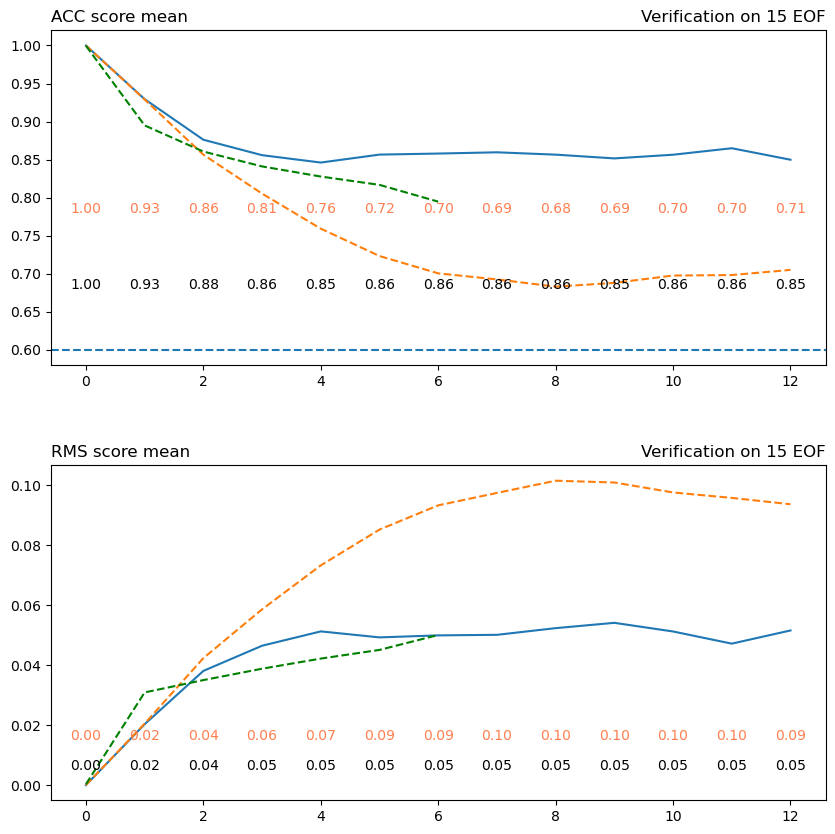

In [53]:
if truncated_verification is None:
    labtit = 'Total verification'
else:
    labtit = f'Verification on {truncated_verification} EOF'
labscore = f'ACC_Score_{case}_{subcase_var}_{subcase}'
utp.plot_skill(corrresult,persistence,rmsres,rmsper,rmsdyn=rmsdyn,corrdyn=corrdyn,skill='mean',numbers=True,printout=True, data_dict=data_dict,
               savefig=False, labtit=labtit,labfile=labscore)

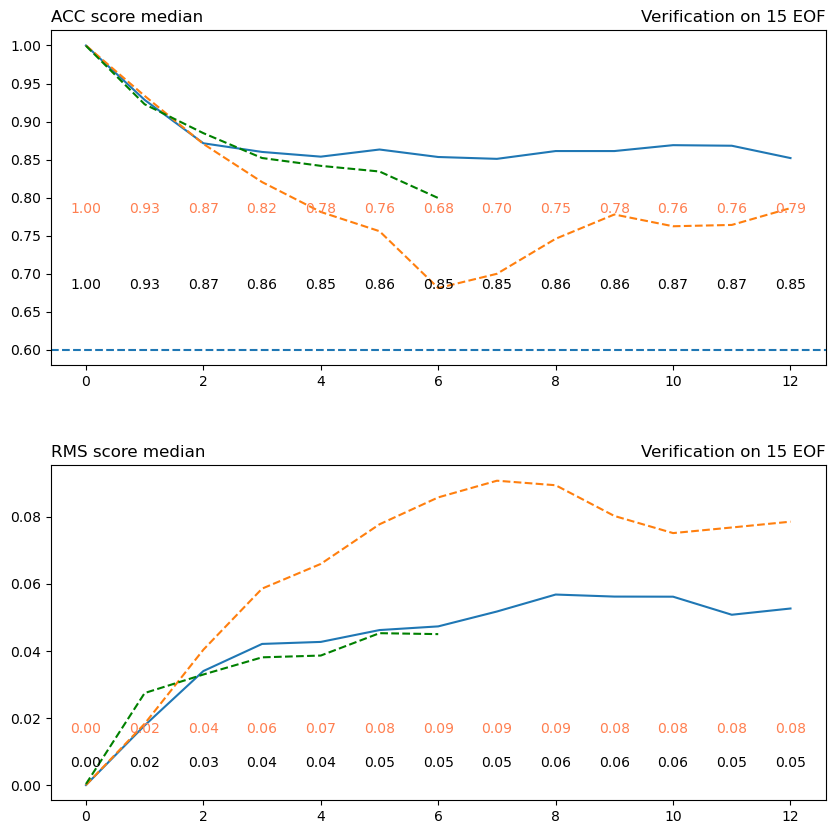

In [54]:
utp.plot_skill(corrresult,persistence,rmsres,rmsper,rmsdyn=rmsdyn,corrdyn=corrdyn,skill='median',numbers=True, printout=False, labtit=labtit,labfile=None)
    

In [55]:
skill = 'median' #'mean'

## Section 6: Forecast Visualization and Diagnostics

Generate comprehensive plots comparing model predictions against observations across:
- Temporal evolution of forecasts
- Spatial patterns of errors
- Lead-time dependence of skill
- Comparison with climatology and dynamical models (if available)

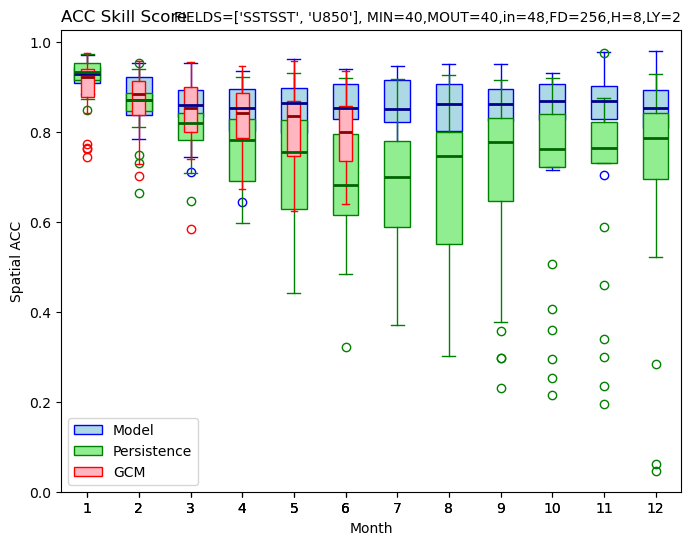

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some example data
np.random.seed(10)
data = [np.random.normal(0, std, 100) for std in range(1, 4)]

# Create a box plot with customization
plt.figure(figsize=(8, 6))
# box = plt.boxplot(corrresult.T, vert=True, patch_artist=True, notch=False, widths=0.2)
# box1 = plt.boxplot(persistence.T, vert=True, patch_artist=True, notch=False, widths=0.2)

#Customizing box plot appearance

# Create a box plot with different colors for each dataset
box1 = plt.boxplot(corrresult[1:,:].T, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', color='blue'),
                  medianprops=dict(color='darkblue',linewidth=2),
                  whiskerprops=dict(color='blue'),
                  capprops=dict(color='blue'),
                  flierprops=dict(markeredgecolor='blue'),
                  )
box2 = plt.boxplot(persistence[1:,:].T, patch_artist=True,
                  boxprops=dict(facecolor='lightgreen', color='green'),
                  medianprops=dict(color='darkgreen',linewidth=2),
                  whiskerprops=dict(color='green'),
                  capprops=dict(color='green'),
                  flierprops=dict(markeredgecolor='green'),
                  )


if verify_dyn:
    box3 = plt.boxplot(corrdyn[1:,:].T, patch_artist=True, widths=0.25,
                  boxprops=dict(facecolor='lightpink', color='red'),
                  medianprops=dict(color='darkred',linewidth=2),
                  whiskerprops=dict(color='red'),
                  capprops=dict(color='red'),
                  flierprops=dict(markeredgecolor='red'),
                  )

# Add a legend
plt.legend([box1["boxes"][0], box2["boxes"][0],box3["boxes"][0]], ['Model', 'Persistence','GCM'], loc='best')

# Add title and labels
plt.title('ACC Skill Score',loc='left')
plt.title(idfig,loc='right',fontsize=10)
plt.xlabel('Month')
plt.ylabel('Spatial ACC')

# Show the plot
# plt.savefig(f'FIG_{file}_Box.pdf')
plt.show()

In [57]:


fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(8, 8))

# for i in range(1,Tpredict,5):
#     hl,=ax1.plot(times[starttest:endtest+1],corrresult[i,:],label=f'Month {i}')
#     ax1.plot(times[starttest:endtest+1],persistence[i,:],label=f'Month {i}',color=hl.get_color(), linestyle='dashed')
idfig = f"FIELDS={figinfield}, MIN={MIN},MOUT={K},in={TIN},FD={params['FFN_DIM']}"
    
# ax1.set_ylim(-0.4,1.2)
# ax1.set_title('Skill Score Median',loc='left')
# ax1.set_title(idfig,loc='right',fontsize=10)
# ax1.legend()
skill='median'

tim = np.arange(0,Tpredict+1)

match skill:
    case 'mean':
        sk = np.mean(corrresult,axis=1)
        ps = np.mean(persistence,axis=1)
        if verify_dyn:
            dyn = np.mean(corrdyn,axis=1)  # Start from month 1
        ax2.plot(tim,corrresult.mean(axis=1)+corrresult.std(axis=1),color='pink',alpha=0.5)
        ax2.plot(tim,corrresult.mean(axis=1)-corrresult.std(axis=1),color='pink',alpha=0.5)
    case 'median':
        sk = np.median(corrresult,axis=1)
        ps = np.median(persistence,axis=1)
        if verify_dyn:
            dyn = np.median(corrdyn,axis=1)  # Start from month 1
        ax2.plot(tim,np.median(corrresult,axis=1)+corrresult.std(axis=1),color='pink',alpha=0.5)
        ax2.plot(tim,np.median(corrresult,axis=1)-corrresult.std(axis=1),color='pink',alpha=0.5)
    case _:
        raise ValueError('Invalid skill choice')
ax2.plot(tim,sk)
ax2.plot(tim,ps,linestyle='dashed')
if verify_dyn:
    ax2.plot(tim[0:7],dyn,linestyle='dashed',color='green')
        
ax2.axhline(0.6,linestyle='dashed')
ax2.set_title('Skill score Median',loc='left')
ax2.set_title(idfig,loc='right',fontsize=10)
for ii in range(0,Tpredict+1):
    ax2.text(ii,min(ax2.get_ylim())+0.1,f'{sk[ii]:4.2f}',horizontalalignment='center',color='blue')
    ax2.text(ii,min(ax2.get_ylim())+0.2,f'{ps[ii]:4.2f}',horizontalalignment='center',color='coral')
    
tw = [sum(np.where(corrresult[i,:] > 0.6, 1,0))/Np for i in range(Tpredict)]
ax3.bar(np.arange(1,Tpredict+1),tw)
ax3.set_title('Number of forecasts above 0.6')
ax3.set_xlabel('Months')
# plt.savefig(f'FIG_{file}_{skill}.pdf')
plt.show()

In [67]:
# Worst Forecast
# Three forecast

cday = 12
im = np.argmin(corrresult[cday,:])
print(im, corrresult[cday,im])

Cont = namedtuple('Contours', 'max min int')
cont_ = Cont(2, -2, 0.25)
np.arange(cont_.min,cont_.max,cont_.int)
cont=[cont_.min, cont_.max, cont_.int]
this_forecast = str(Ft.time.isel(time=im).data[()]).split('T')[0]
# cont = []

ftmp = zai.select_fcst(this_forecast, Ft)
dtmp = zai.select_fcst(this_forecast, Dt)
vtmp = Obs.sel(time=ftmp.time)

ax = utp.Three_Forecast_plots(ftmp,vtmp, dtmp,  'SST',  None, cont, this_forecast,\
                   pictimes=[1,2,4], figsize=(24,10), world_projection='Pacific',\
                   colorbars=False, maintitle=f' Worst Forecast at Month {cday} ', picturelabels=None, arealatz=arealatz, arealonz=arealonz, centlon=180,labfile=None)
   

3 0.7164711981137533
 Opening figure , 3 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25


23 0.9804369831394127
 Opening figure , 3 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25


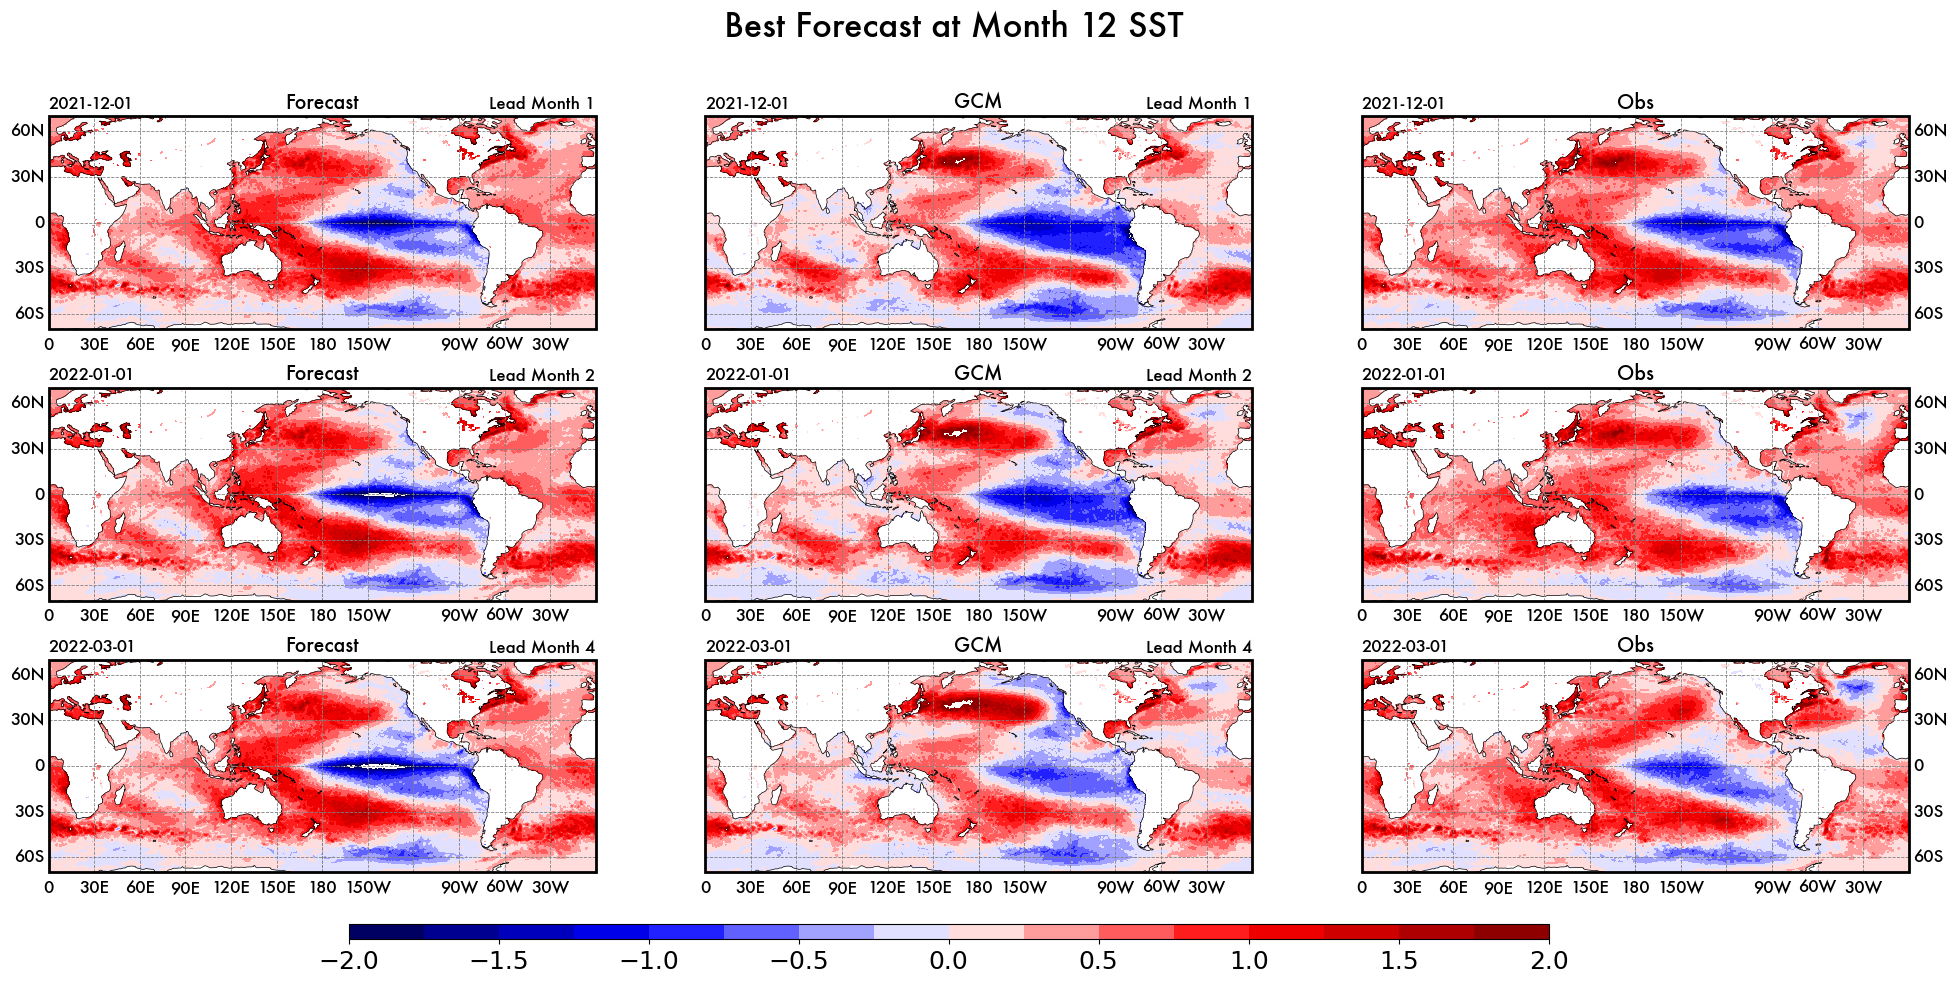

In [68]:
# Best Forecast
# Three forecast

cday = 12
im = np.argmax(corrresult[cday,:])
print(im, corrresult[cday,im])

Cont = namedtuple('Contours', 'max min int')
cont_ = Cont(2, -2, 0.25)
np.arange(cont_.min,cont_.max,cont_.int)
cont=[cont_.min, cont_.max, cont_.int]
this_forecast = str(Ft.time.isel(time=im).data[()]).split('T')[0]
# cont = []

ftmp = zai.select_fcst(this_forecast, Ft)
dtmp = zai.select_fcst(this_forecast, Dt)
vtmp = Obs.sel(time=ftmp.time)

ax = utp.Three_Forecast_plots(ftmp,vtmp, dtmp,  'SST',  None, cont, this_forecast,\
                   pictimes=[1,2,4], figsize=(24,10), world_projection='Pacific',\
                   colorbars=False, maintitle=f' Best Forecast at Month {cday} ', picturelabels=None, arealatz=arealatz, arealonz=arealonz, centlon=180,labfile=None)
   

In [61]:
Np,Nl,NumPoints  = Ft.shape
ERROR = 'L2'

corrresult = np.zeros((Tpredict+1,Np))
persistence = np.zeros((Tpredict+1,Np))
rmsres = np.zeros((Tpredict+1,Np))
rmsper = np.zeros((Tpredict+1,Np))

for idx, ic in enumerate(Ft.time):
    ftmp = zai.select_fcst(ic, Ft)
    ptmp = zai.select_fcst(ic, Pt)
    otmp = Obs.sel(time=ftmp.time)
    corrresult[:,idx] = xr.corr(otmp, ftmp, dim='z').data
    persistence[:,idx] = xr.corr(otmp, ptmp, dim='z').data
    if ERROR == 'L1':
        rmsres[:,idx] = np.sum(abs(ftmp - otmp),axis=1).data/NumPoints
        rmsper[:,idx] = np.sum(abs(otmp - ptmp),axis=1).data/NumPoints
    else:
        rmsres[:,idx] = np.sum(abs(ftmp - otmp)**2,axis=1).data/NumPoints
        rmsper[:,idx] = np.sum(abs(otmp - ptmp)**2,axis=1).data/NumPoints
    



 Opening figure , 4 rows and 2 cols 

Setting Fixed Contours
 Contouring from  -1   to 1  with interval   0.25
Setting Fixed Contours
 Contouring from  -1   to 1  with interval   0.25
Setting Fixed Contours
 Contouring from  -1   to 1  with interval   0.25
Setting Fixed Contours
 Contouring from  -1   to 1  with interval   0.25
Setting Fixed Contours
 Contouring from  -1   to 1  with interval   0.25
Setting Fixed Contours
 Contouring from  -1   to 1  with interval   0.25
Setting Fixed Contours
 Contouring from  -1   to 1  with interval   0.25
Setting Fixed Contours
 Contouring from  -1   to 1  with interval   0.25
Setting Fixed Contours
 Contouring from  -1   to 1  with interval   0.25
Setting Fixed Contours
 Contouring from  -1   to 1  with interval   0.25
Setting Fixed Contours
 Contouring from  -1   to 1  with interval   0.25
Setting Fixed Contours
 Contouring from  -1   to 1  with interval   0.25
Setting Fixed Contours
 Contouring from  -1   to 1  with interval   0.25
Setting Fixed

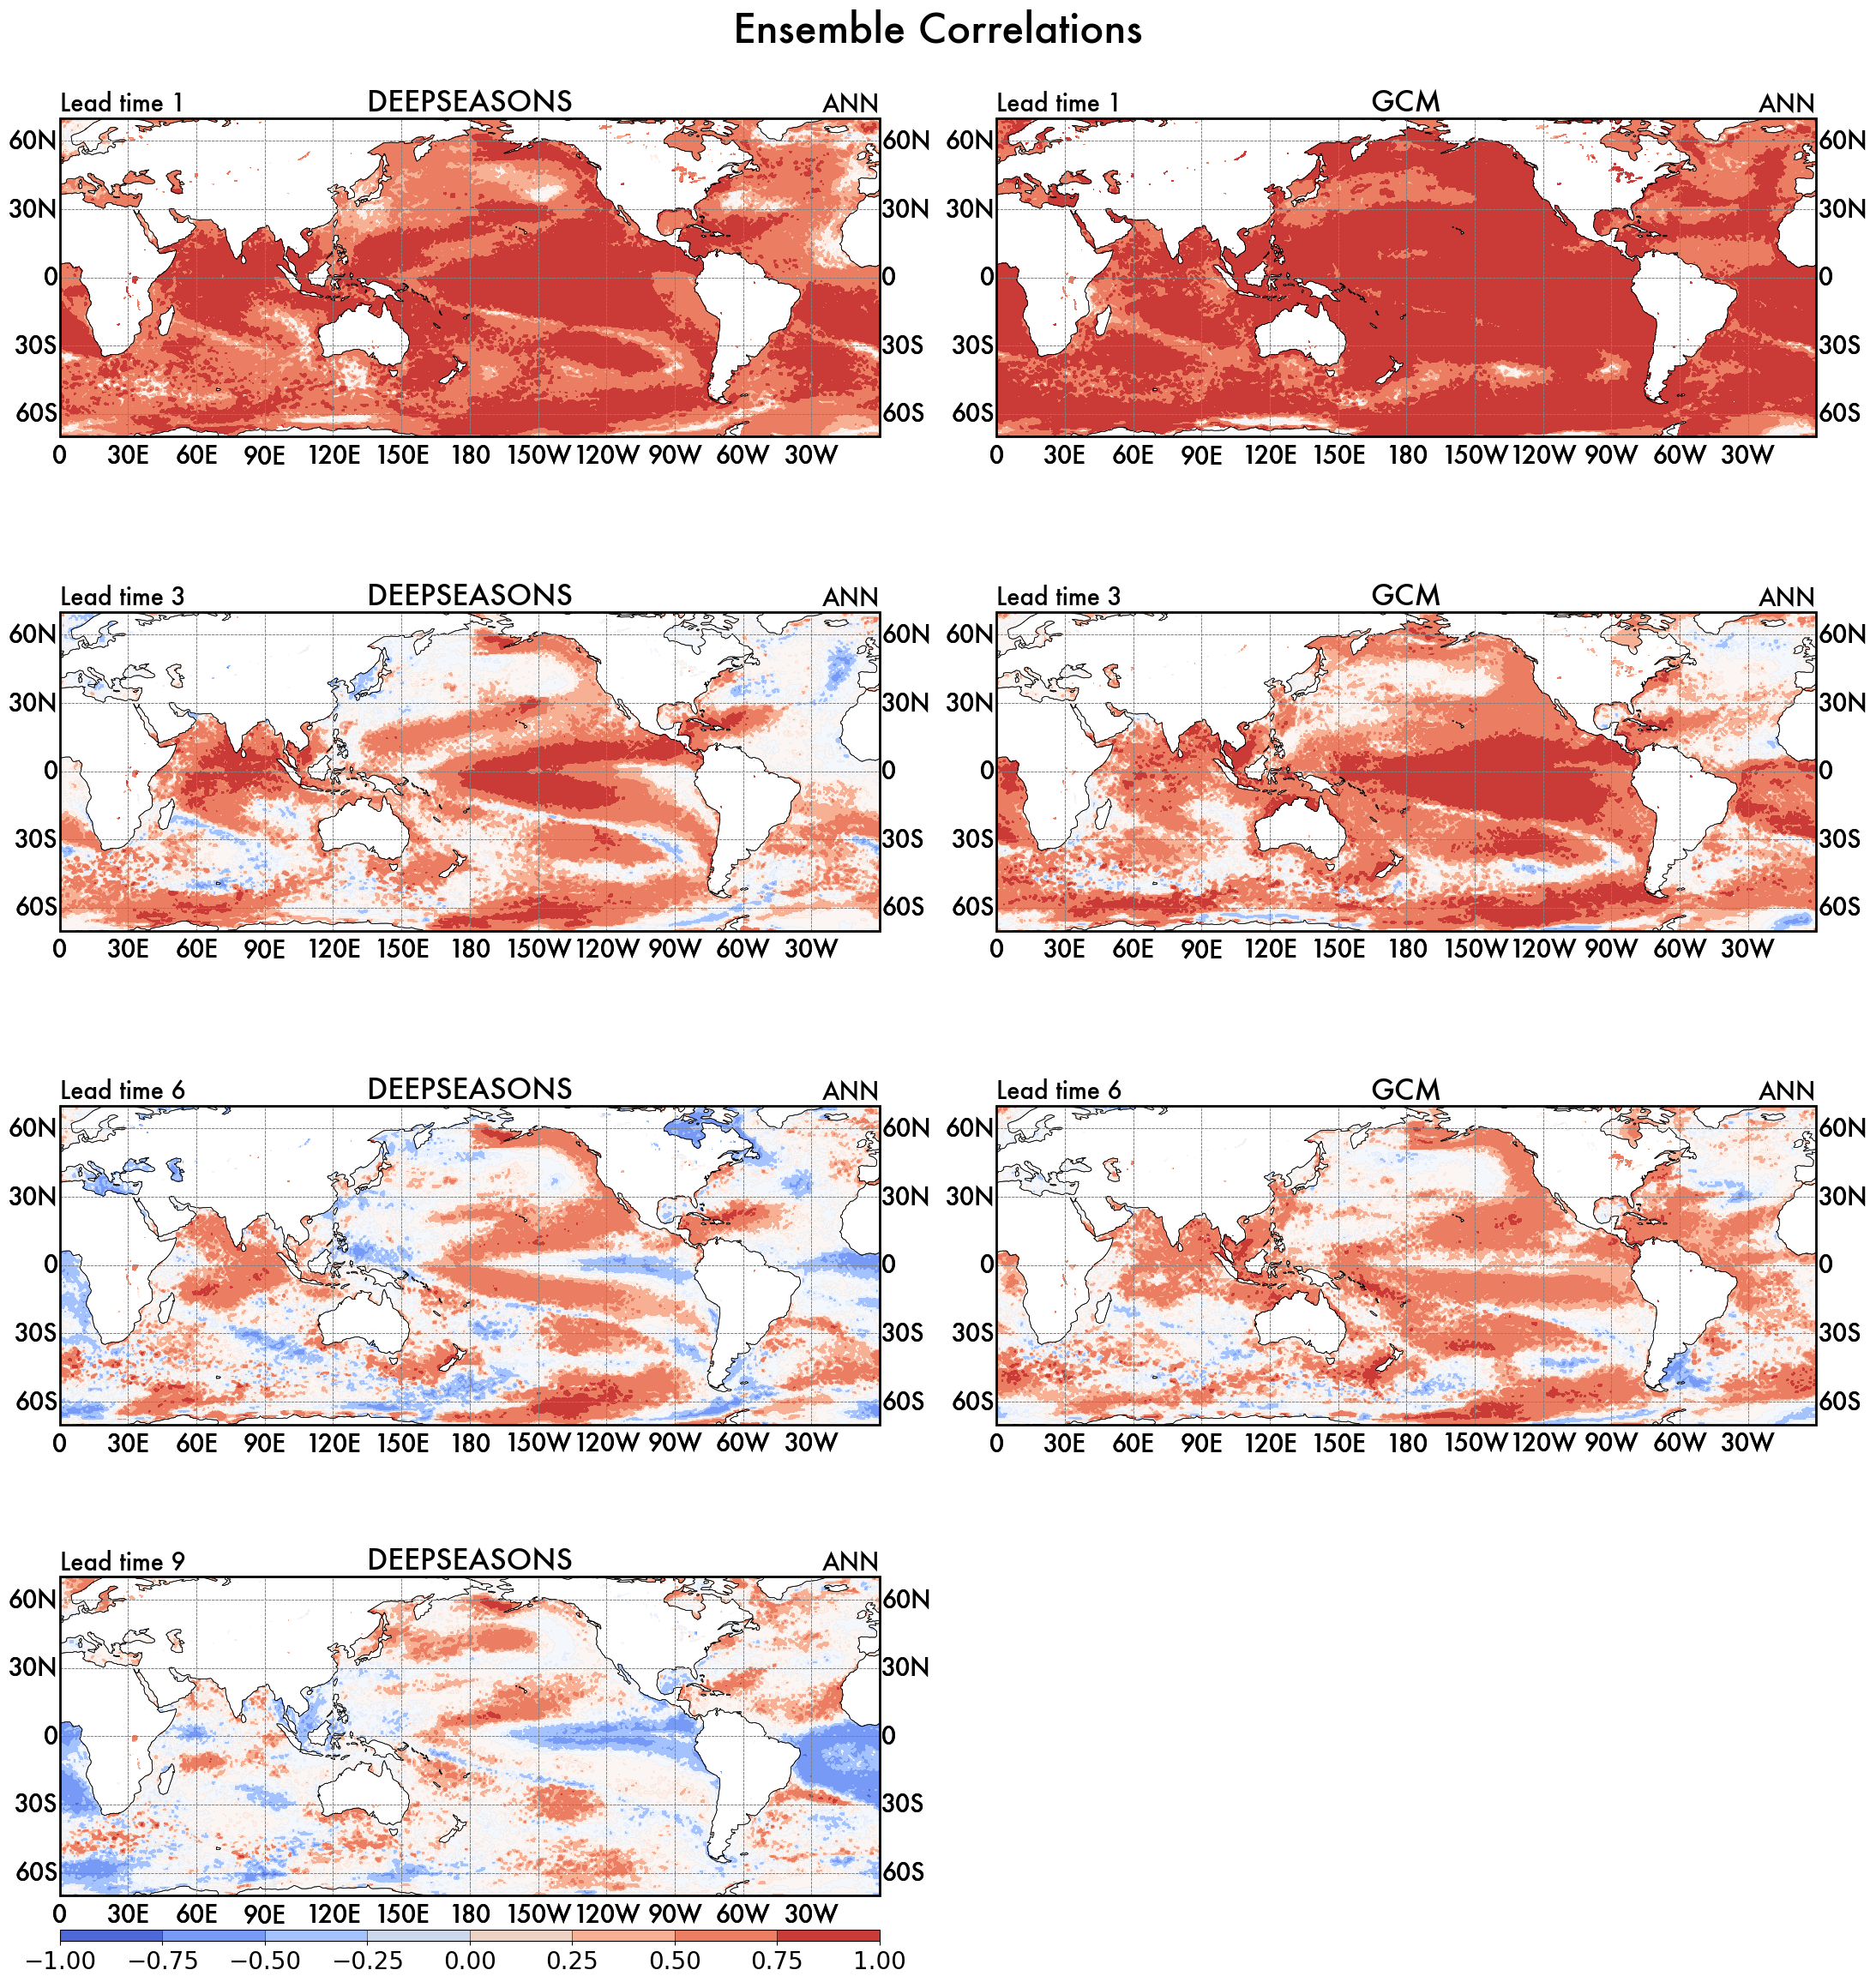

In [62]:
#Plot time correlation
Nplfield = INX[plfield]['mr']

nameeof = zai.select_field_key(INX,plfield,'field')
arealat = zai.select_field_key(INX,plfield,'arealat')

plpro = 'Pacific'
if INX[plfield]['area'] == 'EUROPE':
    plpro = 'Atlantic'
slim=4.0
cont1=[-slim,slim,0.5]
cont2=[-slim,slim,0.5]
cont1=[-1,1,0.25]
cont2=cont1
monlab = 'ANN'
# monlab= [12,1,2]

fig,axu,pro=zmap.init_figure(4,2,plpro, constrained_layout=False, figsize=(22,24) )

if_time = [1,3,6,9]

for ind, this in enumerate(if_time):
    label1 = f'{monlab}'
    index = utp.select_months(Ft.time, monlab)
    Zt = Ft.isel(time=index).sel(lead=this).assign_coords(time=Ft.isel(time=index).sel(lead=this).valid_time)
    PZt = Pt.isel(time=index).sel(lead=this).assign_coords(time=Pt.isel(time=index).sel(lead=this).valid_time)
    if this < 7:
        indexd = utp.select_months(Dt.time, monlab)
        DZt = Dt.isel(time=indexd).sel(lead=this).assign_coords(time=Pt.isel(time=indexd).sel(lead=this).valid_time)
        DVt = Obs.sel(time=DZt.time) 
    Vt = Obs.sel(time=Zt.time)    
    
    xcc0=xr.corr(Zt, Vt, dim='time')
    xcc1=xr.corr(DZt, DVt, dim='time')
    sig0, _ = utp.calculate_significance(xcc0,len(Zt.time),alpha=0.1,two_tailed=True)
    sig1, _ = utp.calculate_significance(xcc1,len(DVt.time),alpha=0.1,two_tailed=True)
    
    handle=zmap.xmap(xcc0.unstack(),cont1, pro, ax=axu[ind,0],refline=None, c_format='{:4.2f}',data_cent_lon=INX[plfield]['centlon'],
                           xlimit=(arealon[0],arealon[1]), ylimit=(arealat[1],arealat[0]), title_style={ "fontsize": 24}, label_style={ "fontsize": 20},
                     title={'maintitle':'DEEPSEASONS', 'lefttitle':f'Lead time {this}','righttitle':label1},cmap='coolwarm',contour=False)
  
    handle['filled'].set_alpha(0.2)
    mask = sig0.unstack().notnull()
    han1=zmap.xmap(sig0.unstack(), cont1, plpro, ax=axu[ind,0], refline=None,c_format='{:4.2f}',data_cent_lon=INX[plfield]['centlon'],
                           xlimit=(arealon[0],arealon[1]),ylimit=(arealat[1],arealat[0]),title_style={ "fontsize": 24}, label_style={ "fontsize": 20},
                   title={'maintitle':'DEEPSEASONS', 'lefttitle':f'Lead time {this}','righttitle':label1},cmap='coolwarm',contour=False)
  
    zmap.changebox(axu[ind,0],'all',linewidth=2,color='black',capstyle='round')
    if this == if_time[-1]:
        cax=zmap.add_colorbar(fig, han1['filled'], axu[ind,0],colorbar_size=0.25,label_size=20,edges=True)
        #Set colorbar labels to bold
        cax.xaxis.label.set_fontweight('bold')
        cax.xaxis.label.set_fontname('Futura')
        cax.xaxis.label.set_size(14)

    if this < 7:
        han11=zmap.xmap(xcc1.unstack(), cont2, plpro, ax=axu[ind,1], refline=None,c_format='{:4.2f}',data_cent_lon=INX[plfield]['centlon'],
                xlimit=(arealon[0],arealon[1]),ylimit=(arealat[1],arealat[0]),title_style={ "fontsize": 24}, label_style={ "fontsize": 20},
                title={'maintitle':'GCM', 'lefttitle':f'Lead time {this}','righttitle':label1},cmap='coolwarm',contour=False)
        han11['filled'].set_alpha(0.2)
        han12=zmap.xmap(sig1.unstack(), cont2, plpro, ax=axu[ind,1], refline=None,c_format='{:4.2f}',data_cent_lon=INX[plfield]['centlon'],
                           xlimit=(arealon[0],arealon[1]),ylimit=(arealat[1],arealat[0]),title_style={ "fontsize": 24}, label_style={ "fontsize": 20},
                   title={'maintitle':'GCM', 'lefttitle':f'Lead time {this}','righttitle':label1},cmap='coolwarm',contour=False)
        zmap.changebox(axu[ind,1],'all',linewidth=2,color='black',capstyle='round')
        
    else:
        axu[ind,1].axis('off')
   
    labfile =  f'TIMECORR{data_name}SST{monlab}_{this}.pdf'
 
    # # Create an axis on the bottom  of the figure for the colorbar 
    # cax = fig.add_axes([0.5, 0.1, 0.5, 0.015])
    # # Create a colorbar based on the first image
    # cbar = fig.colorbar(han1['filled'], cax=cax, orientation='horizontal' )
    # cax.tick_params(labelsize=20)

# fig.colorbar(han1['filled'], ax=axu[ind,0], orientation='vertical', fraction=.05)

plt.suptitle('Ensemble Correlations',fontname='Futura', fontsize=34)
plt.tight_layout()
# fig.subplots_adjust(wspace=0.1,hspace=0.2)
plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show()

In [64]:
figfilename = f'FIG_SUB{subcase_var}_TRIAL{subcase}'

23 0.9804369831394127
 Opening figure , 3 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25


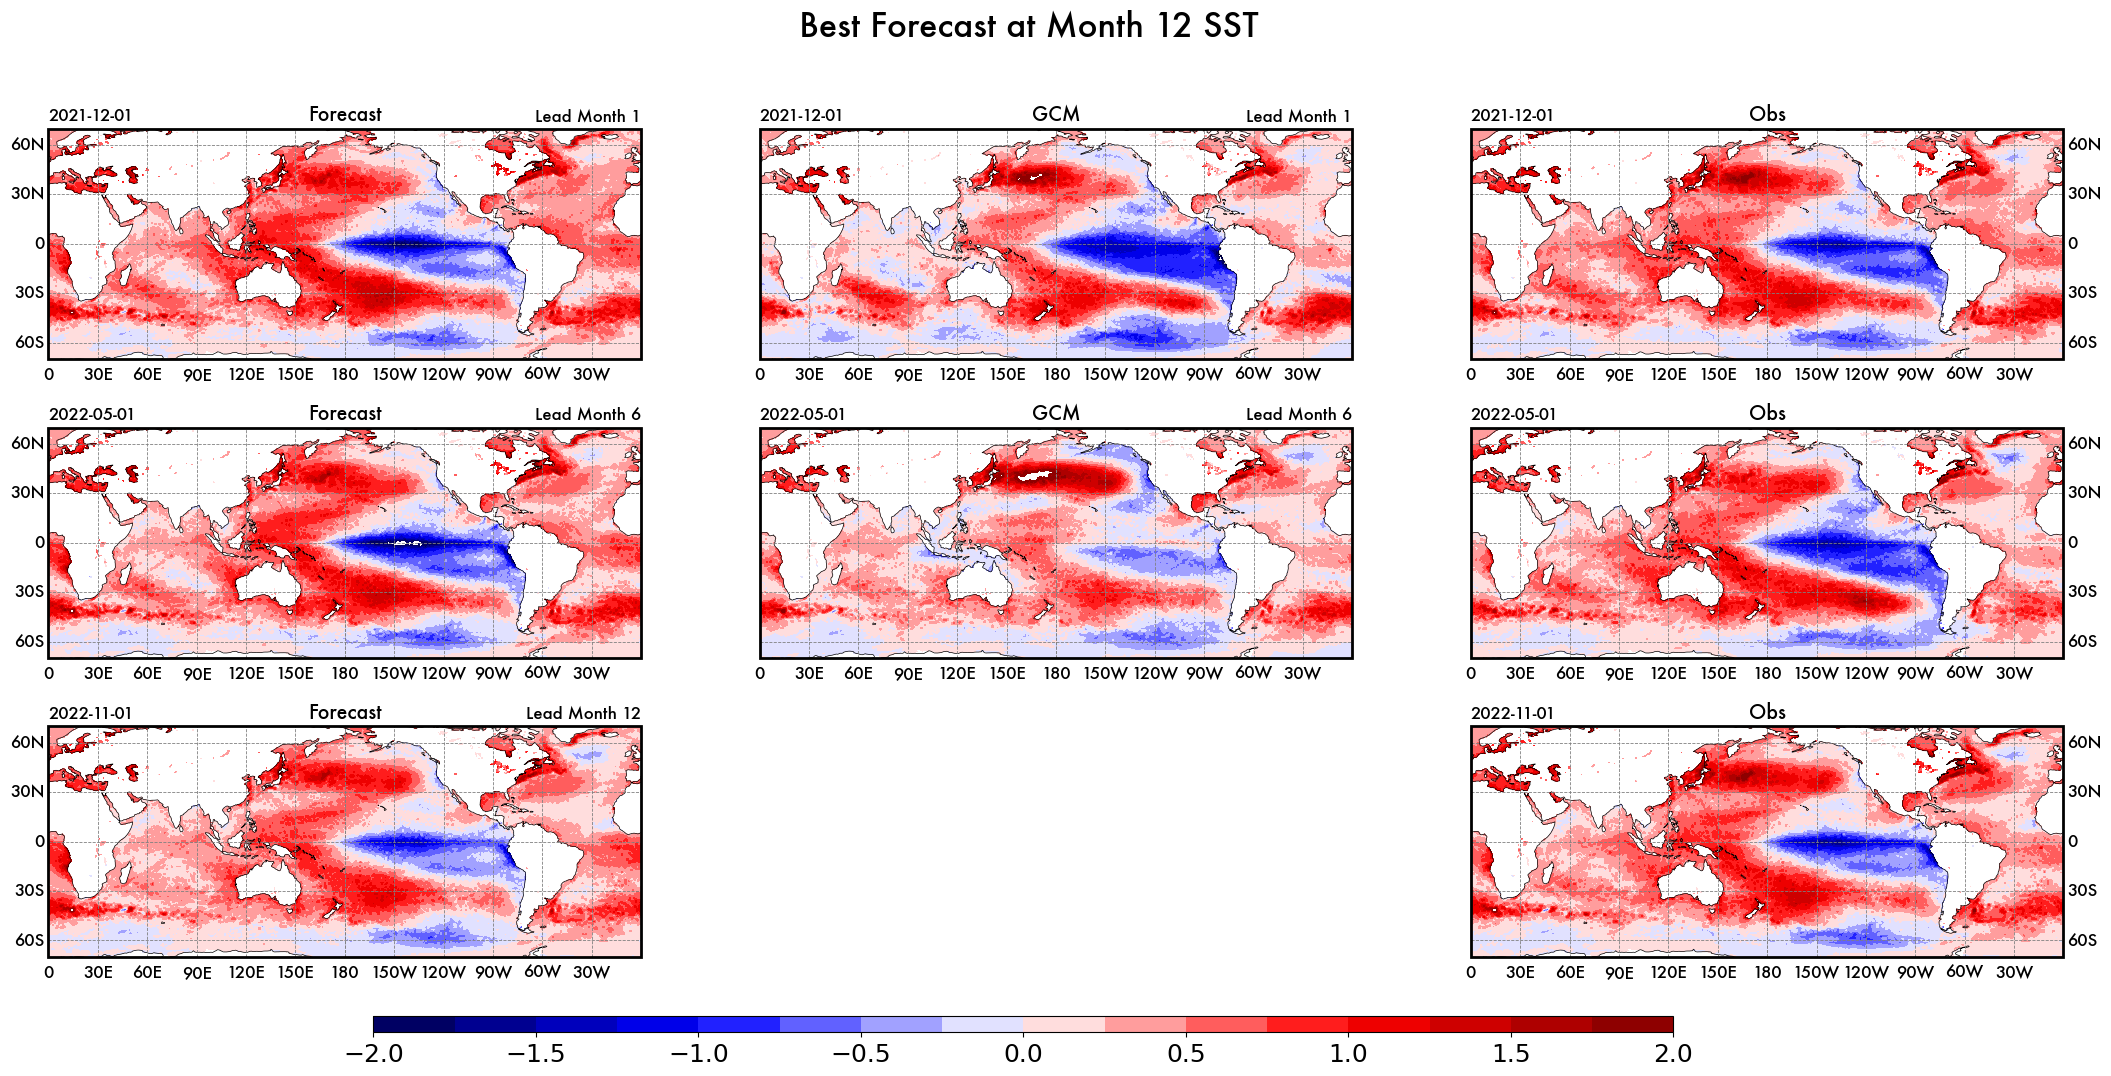

In [65]:
# Best Forecast
# Three forecast

cday = 12
im = np.argmax(corrresult[cday,:])
print(im, corrresult[cday,im])

Cont = namedtuple('Contours', 'max min int')
cont_ = Cont(2, -2, 0.25)
np.arange(cont_.min,cont_.max,cont_.int)
cont=[cont_.min, cont_.max, cont_.int]
this_forecast = str(Ft.time.isel(time=im).data[()]).split('T')[0]
# cont = []

ftmp = zai.select_fcst(this_forecast, Ft)
dtmp = zai.select_fcst(this_forecast, Dt)
vtmp = Obs.sel(time=ftmp.time)
fname = f'BEST{figfilename}.pdf'
ax = utp.Three_Forecast_plots(ftmp,vtmp, dtmp,  'SST',  None, cont, this_forecast,\
                   pictimes=[1,6,12], figsize=(26,11), world_projection='Pacific',\
                   colorbars=False, maintitle=f' Best Forecast at Month {cday} ', picturelabels=None, arealatz=arealatz, arealonz=arealonz, centlon=180,labfile=fname)
   

3 0.7164711981137533
 Opening figure , 3 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.25


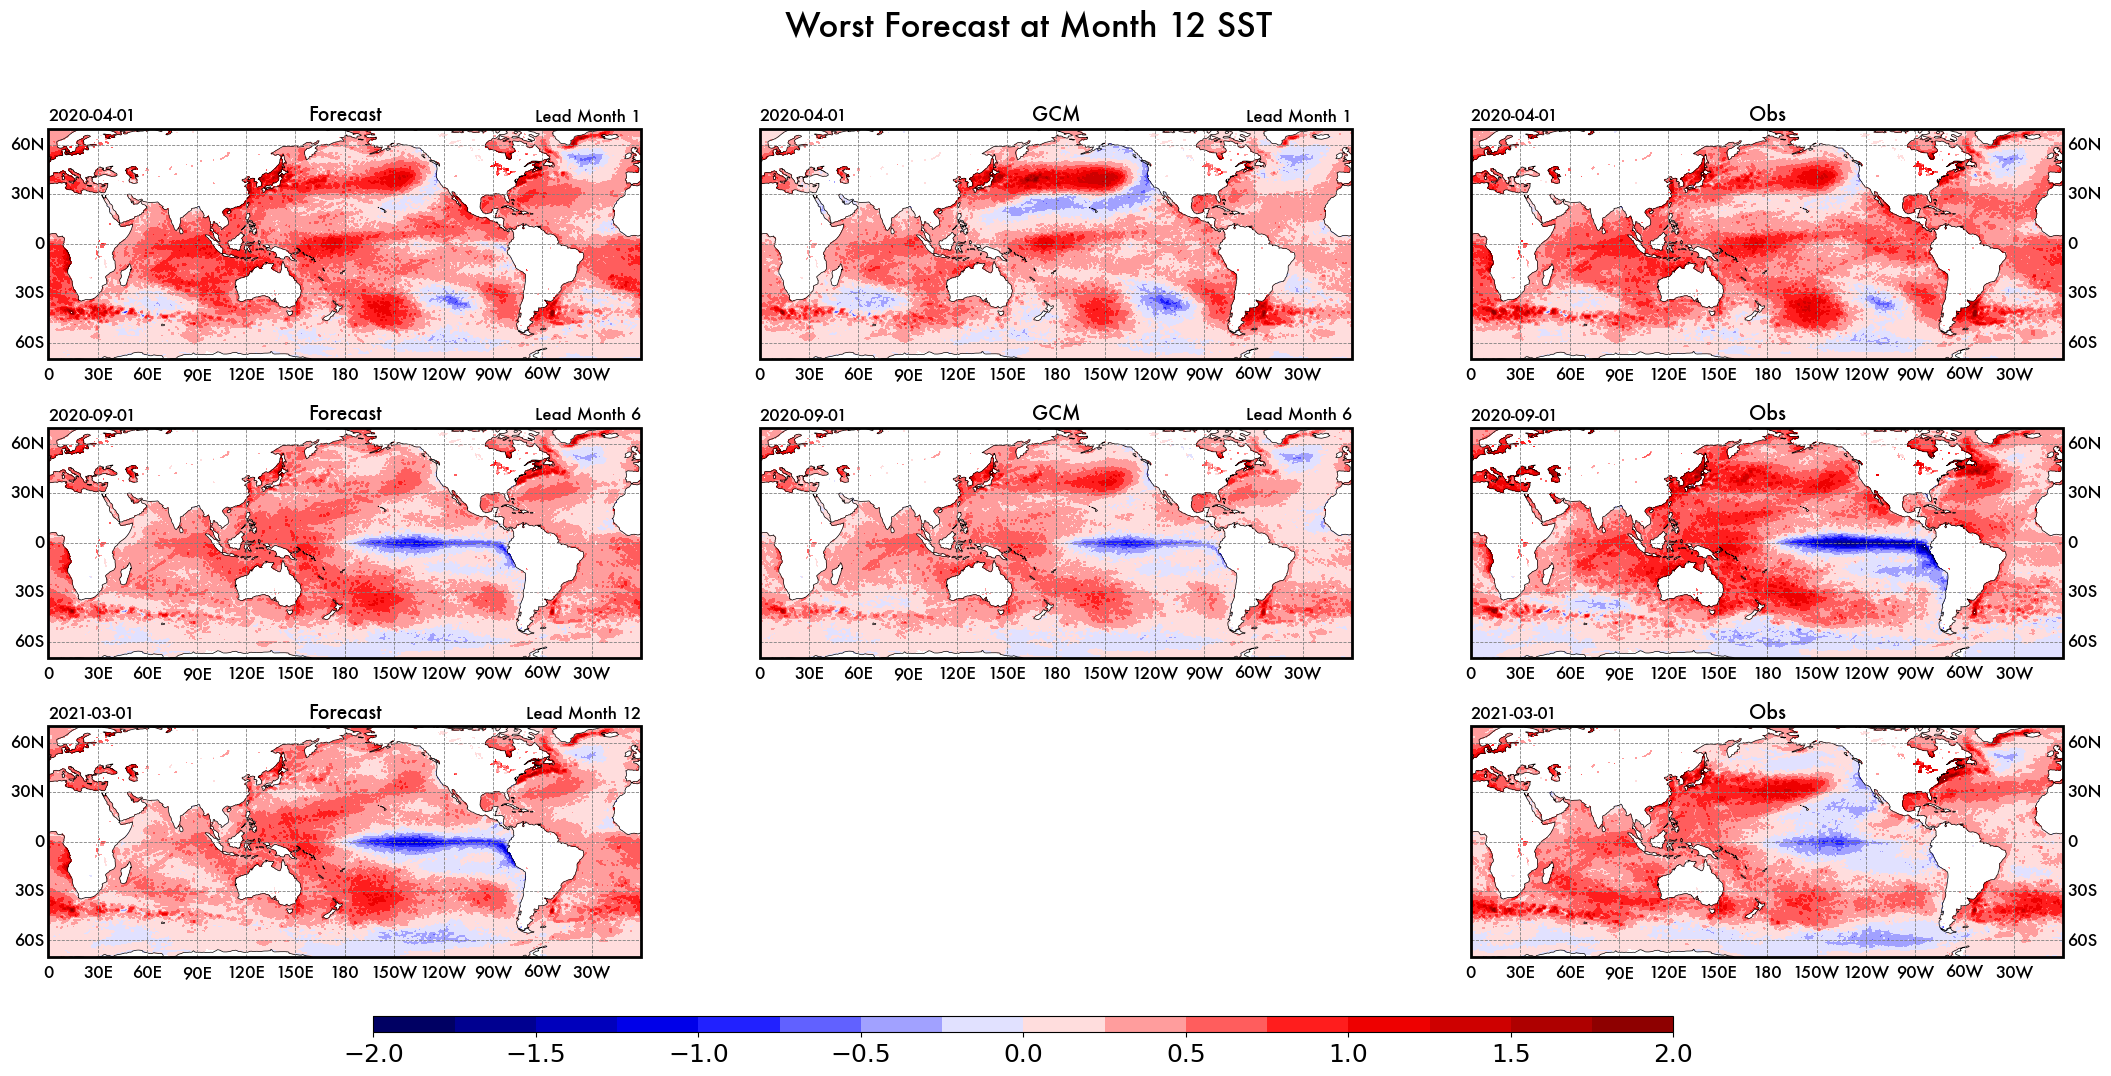

In [66]:
# Worst Forecast
# Three forecast

cday = 12
im = np.argmin(corrresult[cday,:])
print(im, corrresult[cday,im])
fname = fname.replace('BEST','WORST')
Cont = namedtuple('Contours', 'max min int')
cont_ = Cont(2, -2, 0.25)
np.arange(cont_.min,cont_.max,cont_.int)
cont=[cont_.min, cont_.max, cont_.int]
this_forecast = str(Ft.time.isel(time=im).data[()]).split('T')[0]
# cont = []

ftmp = zai.select_fcst(this_forecast, Ft)
dtmp = zai.select_fcst(this_forecast, Dt)
vtmp = Obs.sel(time=ftmp.time)

ax = utp.Three_Forecast_plots(ftmp,vtmp, dtmp,  'SST',  None, cont, this_forecast,\
                   pictimes=[1,6,12], figsize=(26,11), world_projection='Pacific',\
                   colorbars=False, maintitle=f' Worst Forecast at Month {cday} ', picturelabels=None, arealatz=arealatz, arealonz=arealonz, centlon=180,labfile=fname)
   